In [1]:
import pandas as pd
import seaborn as sns
import pickle
import math
import matplotlib.pyplot as plt
import numpy as np
import requests
from urllib.request import urlopen
from bs4 import BeautifulSoup
from scipy import stats
no_exe=False

In [2]:
#Carico i dati sui qui andrò a lavorare
path_file=r'C:\Users\Nico\Desktop\Tirocinio\Dati'
df = pickle.load(open(path_file+'/dblp-with-cite.p','rb'))

In [3]:
#PULIZIA DATI: non considero gli articoli per i quali non è stato possibile estrarre le citazioni 
df = df[df['CIT']>-1]

#PULIZIA DATI: non considero gli articoli dal 2018 in poi per non essere tratti in inganno dalla 'gioventù' del articolo
df = df[df['year']<str(2018)]

#PULIZIA DATI: per ogni anno calcolo il numero di articoli presenti nel mio dataframe per vedere a partire da quale anno 
#si inizia ad avere una quantità di dati significativi.
df_groupby_year = df.groupby(['year']).CIT.count()
print(df_groupby_year)
#Analizzando df_groupby_year secondo me si può partire dal 1985 in quanto da li in poi abbiamo sempre più di 2500 articoli
df = df[df['year']>str(1984)]

#PULIZIA DATI: non cansidero gli articoli per cui non è definito la conferenza a cui appartengono
df = df[df['crossref']!='']

year
1960         9
1961        26
1962        16
1963        13
1964        42
1965        51
1966       157
1967       242
1968       287
1969       299
1970       259
1971       297
1972       563
1973       729
1974      1092
1975       967
1976      1197
1977       842
1978      1261
1979      1337
1980      1635
1981      1625
1982      1790
1983      1799
1984      2501
1985      2562
1986      3045
1987      3692
1988      5627
1989      6800
1990      8472
1991      8978
1992     10003
1993     11418
1994     15565
1995     16576
1996     17972
1997     20381
1998     23128
1999     25377
2000     29245
2001     32403
2002     38366
2003     44920
2004     57753
2005     70444
2006     81955
2007     87502
2008     91947
2009     98647
2010    102431
2011    114900
2012    118111
2013    124684
2014    129896
2015    133604
2016    132121
2017    138197
Name: CIT, dtype: int64


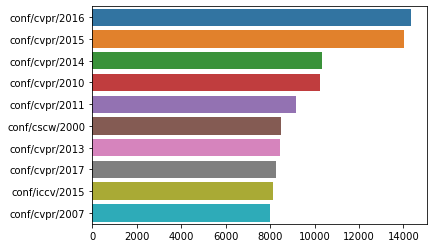

In [4]:
#Estrago la top 10 delle conferenze 
top10 = {v:k for v,k in df.groupby(['crossref']).CIT.sum().sort_values(ascending=False).head(10).items()}
top10_plot = sns.barplot(x=list(top10.values()), y=list(top10.keys()))

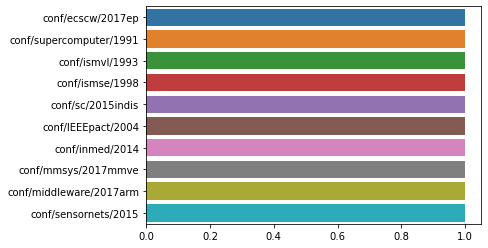

In [5]:
#Estrago la flop 10 delle conferenze esclundendo però quelle con 0 citazioni 
flop10 = {v:k for v,k in df[df['CIT']>0].groupby(['crossref']).CIT.sum().sort_values().head(10).items()}
flop10_plot = sns.barplot(x=list(flop10.values()), y=list(flop10.keys()))

In [6]:
#Raggruppo gli articoli per conferenze, calcolo le citazioni totali, il numero di articoli, le citazioni medie e creo un 
#dataframe con le informazioni estratte
#Pe ora mi limito ad analizzare ogni singola conferenza anno per anno. 

single_conference_cit = df.groupby(['crossref']).CIT.sum().sort_values(ascending=False)
single_conference_count_article = df.groupby(['crossref']).CIT.count().sort_values(ascending=False)

#Calcolo delle citazioni medie
single_conference_avg_cit = {key:(int(val)/int(single_conference_count_article[key])) for key,val in single_conference_cit.items()}

#Con i dati estratti creo un dictionary che mi facilita la creazione del dataframe
single_conference = {k:[v,single_conference_avg_cit[k],single_conference_count_article[k]] for k,v in single_conference_cit.items()}
df_single_conference = pd.DataFrame(data=single_conference.values(), index=single_conference.keys(), columns=['CIT TOT', 'CIT AVG', 'N.ARTICLES'])
df_single_conference = df_single_conference.sort_values('CIT AVG', ascending=False)
df_single_conference.head(10)

,CIT TOT,CIT AVG,N.ARTICLES
conf/cscw/2000,8471,162.903846,52
conf/mobicom/2000,3566,127.357143,28
conf/crypto/2001,3947,119.606061,33
conf/wmcsa/1999,1429,119.083333,12
conf/eurocrypt/2005,3804,115.272727,33
conf/eurocrypt/2004,3935,109.305556,36
conf/crypto/1999,3995,102.435897,39
conf/sigcomm/2001,2266,98.521739,23
conf/adaptive/2007,2074,86.416667,24
conf/sosp/2003,1805,82.045455,22


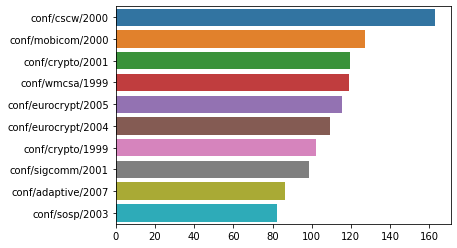

In [7]:
#TOP 10 PER MEDIA CITAZIONI 
top10_avg = {k:v for k,v in df_single_conference['CIT AVG'].sort_values(ascending=False).head(10).items()}
top10_avg_plot = sns.barplot(x=list(top10_avg.values()), y=list(top10_avg.keys()))

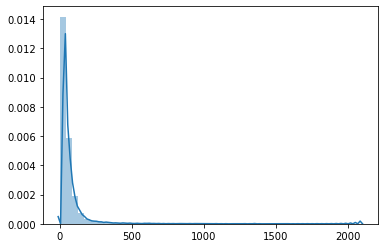

In [8]:
#Possiamo notare che la top 10 delle citazioni totali è diversa dalla top 10 delle citazioni media
#Dobbiamo considerare quindi anche le conferenze con poche citazioni totali ma con un alto valore di citazioni medie
#Può essere interessante quindi capire quanti articoli ci sono in media in una conferenza 

article_by_conference_plot = sns.distplot([v for k,v in single_conference_count_article.items()])
avg_article_by_conference = sum([v for k,v in single_conference_count_article.items()])/len(single_conference_count_article)

In [9]:
#Possiamo quindi notare che ci sono, anche se poche, conferenze che superano anche i 2000 articoli, ma la media 
# è di circa 61 articoli a conferenza. La maggior parte delle conferenze oscilla tra i 10 e i 200 articoli. 

In [10]:
#Possiamo ora passare ad analizzare l'evoluzione delle conferenze, quindi raggrupando gli articoli per conferenza 
#come prima ma senza tenere conto degli anni.
#Per prima cosa creamo un dataframe come quello di prima quindi con citazioni totali medie e numero di articoli
#ma quesat volta senza appunto distinguere per anno 

#Per identificare le conferenza utilizziamo la colonna 'crossref', ma sta volta dobbiamo splitarla in modo da 
#eliminare l'anno
df[['conf','cod', 'anno']] = df.crossref.str.split("/",expand=True,)
#Fatto ciò, andiamo a raggrupare per cod, sommiamo le citazioni, e contiamo gli articoli per poi calcolare la media 
conference_tot_cit = df.groupby(['cod']).CIT.sum()
conference_tot_article = df.groupby(['cod']).CIT.count()
avg_cit_for_conference = {key:(int(val)/int(conference_tot_article[key])) for key,val in conference_tot_cit.items()}

#Una volta estratti i dati creiamo un dictionary per facilitare la creazione del dataframe
conference = {k:[v,avg_cit_for_conference[k],conference_tot_article[k]] for k,v in conference_tot_cit.items()}
df_conference = pd.DataFrame(data=conference.values(), index=conference.keys(), columns=['CIT TOT', 'CIT AVG', 'N.ARTICLES'])
df_conference = df_conference.sort_values(['CIT AVG'], ascending=False)
df_conference.head(10)

,CIT TOT,CIT AVG,N.ARTICLES
adaptive,2074,86.416667,24
diau,789,71.727273,11
banff,226,45.200000,5
crypto,59794,41.872549,1428
eurocrypt,52855,40.347328,1310
ismb,10875,35.655738,305
mobidata,920,35.384615,26
mas,445,34.230769,13
iptps,3177,28.366071,112
ches,15108,24.848684,608


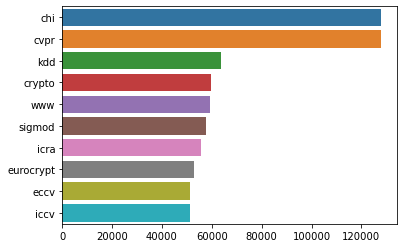

In [11]:
#Estrago le 10 conferenze che hanno accumulato più citazioni in tutte le loro citazioni
top10_conference_by_cit ={k:v for k,v in df_conference['CIT TOT'].sort_values(ascending=False).head(10).items()}
top10_conference_by_cit_plot = sns.barplot(x=list(top10_conference_by_cit.values()), y=list(top10_conference_by_cit.keys()))

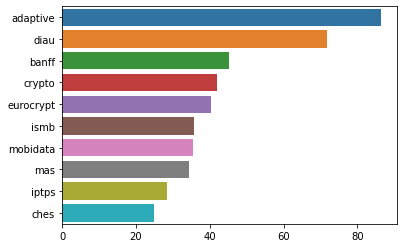

In [12]:
#Estrago le 10 conferenze con media citazioni più alta
top10_conference_by_avgCit ={k:v for k,v in df_conference['CIT AVG'].sort_values(ascending=False).head(10).items()}
top10_conference_by_avgCit_plot = sns.barplot(x=list(top10_conference_by_avgCit.values()), y=list(top10_conference_by_avgCit.keys()))

In [13]:
#Quello che ci interessa però principalmente è l'evoluzione di ogni conferenza quindi andiamo a creare un dataframe dove 
#l'index identifica la conferenza e nelle colonne troviamo citazioni totali e medie per ogni anno
lst_dataframes = []
conference_tot_cit = df.groupby(['cod','year']).CIT.sum()
conference_tot_article = df.groupby(['cod','year']).CIT.count()
keys = df.groupby(['cod']).CIT.count().keys()
for conference in keys:
    single_conference = {}
    tot_cit = 0
    tot_article = 0
    n_editions = 0
    for k,v in conference_tot_cit[conference].items():
        single_conference[str(k)+'-CIT'] = v   #calcolo cit totali per ogni anno in cui si è tenuta la conferenza
        single_conference[str(k)+'-AVG'] = v/conference_tot_article[conference][k] #calcolo citazioni medie per ogni anno 
        tot_cit += v #calcolo cit totali
        tot_article += conference_tot_article[conference][k]  #calcolo numero totali di articoli
        n_editions += 1 #calcolo numero di edizioni per ogni conferenza
    single_conference['tot_cit'] = tot_cit
    single_conference['avg_cit'] = tot_cit/tot_article
    single_conference['n_editions'] = n_editions
    #creo una lista di dataframe, ogni dataframe corrisponde ad una conferenza
    lst_dataframes.append(pd.DataFrame(data=[single_conference.values()], index = [conference], columns=single_conference.keys()))
#unisco tutti i dataframe creati
df_conf_evolution = pd.concat(lst_dataframes)
#ordino le colonne in ordine alfabetico
df_conf_evolution = df_conf_evolution.reindex(sorted(df_conf_evolution.columns), axis=1)
#ordino le righe in base alle citazioni medie
df_conf_evolution = df_conf_evolution.sort_values(['n_editions'], ascending=False)
df_conf_evolution.head(10)

,1985-AVG,1985-CIT,1986-AVG,1986-CIT,1987-AVG,1987-CIT,1988-AVG,1988-CIT,1989-AVG,1989-CIT,...,2014-CIT,2015-AVG,2015-CIT,2016-AVG,2016-CIT,2017-AVG,2017-CIT,avg_cit,n_editions,tot_cit
sigir,5.500000,176.0,4.085714,143.0,2.468750,79.0,4.533333,204.0,4.111111,111.0,...,2012.0,8.114428,1631.0,5.179487,1212.0,3.560784,908.0,12.343552,33,48720
sigmod,6.000000,240.0,16.135135,597.0,16.644444,749.0,10.057692,523.0,19.357143,813.0,...,2380.0,10.200980,2081.0,5.111538,1329.0,3.233184,721.0,15.943721,33,57509
stacs,2.666667,96.0,3.433333,103.0,6.404255,301.0,2.651163,114.0,2.686275,137.0,...,1.0,0.049180,3.0,0.101695,6.0,0.033898,2.0,3.725943,33,6621
compgeom,7.804878,320.0,9.058824,308.0,8.184211,311.0,8.600000,344.0,6.883721,296.0,...,186.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,4.732265,33,8272
apn,5.166667,124.0,11.625000,186.0,5.750000,115.0,6.318182,139.0,18.944444,341.0,...,87.0,3.588235,61.0,2.000000,38.0,1.052632,20.0,7.096654,33,5727
stoc,15.452830,819.0,20.468085,962.0,44.760000,2238.0,46.754717,2478.0,32.107143,1798.0,...,1143.0,8.903226,828.0,5.597826,515.0,2.990909,329.0,18.465423,33,47530
icra,2.927711,486.0,1.144543,388.0,1.179331,388.0,1.197568,394.0,1.501779,422.0,...,3087.0,2.774468,2608.0,2.343434,1624.0,1.476730,1174.0,2.698717,33,55742
siguccs,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.029851,2.0,0.055556,4.0,...,8.0,0.235294,8.0,0.343750,11.0,0.179487,7.0,0.211650,33,436
pods,5.200000,156.0,12.000000,348.0,10.405405,385.0,9.833333,354.0,13.368421,508.0,...,252.0,4.966667,149.0,4.297297,159.0,3.514286,123.0,14.456480,33,14948
focs,20.114754,1227.0,26.518519,1432.0,18.072727,994.0,17.322034,1022.0,16.252525,1609.0,...,653.0,6.046512,520.0,4.511628,388.0,3.255556,293.0,11.474764,33,27964


In [14]:
#creo un dataframe dove per ogni conferenza seguo l'evoluzione annuale solo delle citazioni medie 
lst_dataframes = []
for conference in keys:
    single_conference = {}
    n_editions = 0
    for k,v in conference_tot_cit[conference].items():
        single_conference[str(k)] = v/conference_tot_article[conference][k] #calcolo citazioni medie per ogni anno
        n_editions +=1
    #creo una lista di dataframe, ogni dataframe corrisponde ad una conferenza
    #Siccome questo dataframe ha lo scopo di analizzare l'evoluzione di una conferenza si possono eliminare tutte le conferenze 
    #che si sono tenute una sola volta
    if n_editions>1:
        lst_dataframes.append(pd.DataFrame(data=[single_conference.values()], index = [conference], columns=single_conference.keys()))
#unisco tutti i dataframe creati
avg_cit_evolution = pd.concat(lst_dataframes)
#ordino le colonne in ordine alfabetico
avg_cit_evolution = avg_cit_evolution.reindex(sorted(avg_cit_evolution.columns), axis=1)
avg_cit_evolution.head(10)

,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
3dic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2.469136,1.136364,0.462963,NaN,0.741573,0.478261,0.375000,0.125000,NaN
3dica,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.764706,NaN,0.870968,2.111111,1.428571,0.645161,0.200000,0.200000,NaN,NaN
3dim,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.833333,3.800000,6.142857,1.733333,1.297297,5.640000,1.424658
3dor,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.111111,0.000000,0.066667,0.000000,0.045455,0.066667,0.111111
3dpvt,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3dtv,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.666667,0.620690,0.606557,0.392857,0.458333,0.290323
3dui,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.216216,2.694444,3.794118,2.416667,2.500000,1.825397,2.722222,1.339286,2.000000,1.830769
3pgcic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.096774,1.074627,0.965517,1.457627,0.669725,0.575163,0.258065,0.227848
ACISicis,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.645455,0.863415,0.972973,0.925373,0.672727,0.595960,0.602273,0.686957,0.635193,0.546012
ACMace,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.621622,1.908163,1.891892,3.372340,1.925373,1.948052,2.356322,1.424242,1.037736,0.593220


In [15]:
#creo un dataframe dove per ogni conferenza seguo l'evoluzione annuale solo delle citazioni totali 
lst_dataframes = []
for conference in keys:
    single_conference = {}
    n_editions = 0
    for k,v in conference_tot_cit[conference].items():
        single_conference[str(k)] = v 
        n_editions += 1
    #creo una lista di dataframe, ogni dataframe corrisponde ad una conferenza
    #Siccome questo dataframe ha lo scopo di analizzare l'evoluzione di una conferenza si possono eliminare tutte le conferenze 
    #che si sono tenute una sola volta
    if n_editions >1:
        lst_dataframes.append(pd.DataFrame(data=[single_conference.values()], index = [conference], columns=single_conference.keys()))
#unisco tutti i dataframe creati
cit_evolution = pd.concat(lst_dataframes)
#ordino le colonne in ordine alfabetico
cit_evolution = cit_evolution.reindex(sorted(cit_evolution.columns), axis=1)
cit_evolution.head(10)

,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
3dic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,200.0,75.0,50.0,NaN,66.0,22.0,30.0,6.0,NaN
3dica,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,26.0,NaN,27.0,95.0,70.0,20.0,3.0,5.0,NaN,NaN
3dim,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,207.0,285.0,344.0,182.0,96.0,423.0,104.0
3dor,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,2.0,0.0,1.0,0.0,1.0,1.0,2.0
3dpvt,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3dtv,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,38.0,18.0,37.0,11.0,11.0,9.0
3dui,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,82.0,97.0,129.0,87.0,125.0,115.0,147.0,75.0,114.0,119.0
3pgcic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,102.0,72.0,56.0,172.0,73.0,88.0,24.0,18.0
ACISicis,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,181.0,177.0,144.0,62.0,74.0,59.0,53.0,79.0,148.0,89.0
ACMace,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,291.0,187.0,70.0,317.0,129.0,150.0,205.0,94.0,55.0,35.0


In [16]:
#Per ogni conferenza creo due liste, una contiene tutti gli anni in cui le citazioni medie sono superiori alle citazioni 
#medie totali, ovvero dal primo anno in cui si è tenuta la conferenza fino al 2017, l'altra lista contiene invece gli anni in
#cui le citazioni medie sono inferiori.
over_and_under_avg_cit = {}
for row,col in avg_cit_evolution.iterrows():
    maggiori = []
    minori = []
    for k,v in col.items():
        if not math.isnan(v):
            if(v >= df_conference.at[row,'CIT AVG']):
                maggiori.append(k)
            else:
                minori.append(k)
    x = {}
    x['confSottoLaMedia']= minori
    x['confSopraLaMedia']= maggiori
    over_and_under_avg_cit[row] = x

In [17]:
#Ora che ho creato il dictionary posso andare a calcolare la percentuale di conferenze sotto la media, andando poi ad 
#analizzare gli estremi, ovvero quelle con più alta o bassa percetuale perché potenzialmente le più significative al nostro fine
lst_df = []
for k,v in over_and_under_avg_cit.items():
    v['%confSottoLaMedia'] = (len(v['confSottoLaMedia'])/df_conf_evolution.at[k,'n_editions'])*100
    lst_df.append(pd.DataFrame(data=[v.values()], index = [k], columns=v.keys()))
    
    
df_over_and_under_avg_cit = pd.concat(lst_df)
df_over_and_under_avg_cit = df_over_and_under_avg_cit.sort_values(['%confSottoLaMedia'], ascending=False)
df_over_and_under_avg_cit.head(10)

,confSottoLaMedia,confSopraLaMedia,%confSottoLaMedia
vast,"[2003, 2004, 2005, 2006, 2007, 2008, 2009, 201...",[2001],92.857143
ccia,"[2008, 2009, 2010, 2011, 2012, 2013, 2014, 201...",[2002],90.909091
tamc,"[2006, 2007, 2009, 2010, 2011, 2012, 2013, 201...",[2008],90.909091
jurix,"[2008, 2010, 2011, 2012, 2013, 2014, 2015, 201...",[2009],90.000000
egItaly,"[2006, 2007, 2010, 2011, 2014, 2015, 2016, 2017]",[2008],88.888889
egve,"[2000, 2001, 2002, 2003, 2004, 2005, 2008, 200...","[2006, 2007]",88.888889
atmos,"[2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]",[2004],88.888889
fit,"[2009, 2010, 2011, 2013, 2014, 2015, 2016]",[2012],87.500000
egh,"[1986, 1987, 1988, 1989, 1990, 1991, 1992, 199...","[2011, 2013, 2015, 2017]",87.096774
iwinac,"[2007, 2009, 2011, 2013, 2015, 2017]",[2005],85.714286


In [18]:
#Possiamo dunque analizzare queste conferenza per capire come mai una o comunque poche conferenze si distinguono rispetto
#alle altre.

In [19]:
#Creo un dictionary dove per ogni conferenza mi salvo anno e citazioni medie di quel anno
#Il dictionary mi serve per facilitare la creazione del grafico con l'andamneto delle citazioni medie negli anni 
dict_avg_cit_conference = {}
for row,col in avg_cit_evolution.iterrows():
    x = {}
    for k,v in col.items():
        if not math.isnan(v):
            x[k] = v
    dict_avg_cit_conference[row] = x

In [20]:
#Creo un dictionary dove per ogni conferenza mi salvo anno e citazioni totali di quel anno
#Il dictionary mi serve per facilitare la creazione del grafico con l'andamneto delle citazioni totali negli anni 
dict_cit_conference = {}
for row,col in cit_evolution.iterrows():
    x = {}
    for k,v in col.items():
        if not math.isnan(v):
            x[k] = v
    dict_cit_conference[row] = x

In [21]:
#Implemento una funzione che dato in input il nome della conferenza disegna il grafico con l'andamento delle citazioni medie
#negli anni 
def draw_avg_cit_graph(conf_name):
    plot = sns.barplot(x=list(dict_avg_cit_conference[conf_name].keys()), y=list(dict_avg_cit_conference[conf_name].values()))
    plot.set_xticklabels(plot.get_xticklabels(), rotation=75)
    plot.set_title(conf_name)
    plot.set(xlabel='YEAR', ylabel='AVG CIT')
    plot.axhline(df_conference.at[conf_name,'CIT AVG'], ls='--')
    plot.text(0.5,int(df_conference.at[conf_name,'CIT AVG'])+0.2, "total avg")

In [22]:
#Implemento una funzione che dato in input il nome della conferenza disegna il grafico con l'andamento delle citazioni medie
#negli anni 
def draw_tot_cit_graph(conf_name):
    plot = sns.barplot(x=list(dict_cit_conference[conf_name].keys()), y=list(dict_cit_conference[conf_name].values()))
    plot.set_xticklabels(plot.get_xticklabels(), rotation=75)
    plot.set_title(conf_name)
    plot.set(xlabel='YEAR', ylabel='CIT')

In [23]:
#Ora non ci resta che capire quali sono le conferenze più interessanti da analizzare
#Sicuramente la top 10 delle conferenze per citazioni totali e citazioni medie ma anche la top 10 delle conferenze che 
#si sono tenute più volte. Tutte informazioni già calcolate non ci resta che estrarle 

print('TOP 10 PER CITAZIONI TOTALI: ' + str(list(top10_conference_by_cit.keys())))
print('TOP 10 PER CITAZIONI MEDIE: ' + str(list(top10_conference_by_avgCit.keys())))

top10_num_editions ={k:v for k,v in df_conf_evolution['n_editions'].sort_values(ascending=False).head(10).items()}
print('TOP 10 PER NUMERO DI EDIZIONI: ' + str(list(top10_num_editions.keys())))

TOP 10 PER CITAZIONI TOTALI: ['chi', 'cvpr', 'kdd', 'crypto', 'www', 'sigmod', 'icra', 'eurocrypt', 'eccv', 'iccv']
TOP 10 PER CITAZIONI MEDIE: ['adaptive', 'diau', 'banff', 'crypto', 'eurocrypt', 'ismb', 'mobidata', 'mas', 'iptps', 'ches']
TOP 10 PER NUMERO DI EDIZIONI: ['sigir', 'pods', 'icalp', 'siggraph', 'sigmetrics', 'sp', 'podc', 'fsttcs', 'focs', 'crypto']


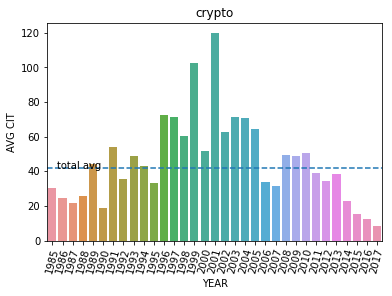

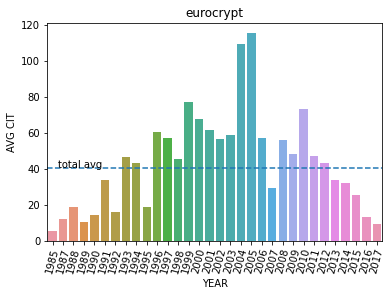

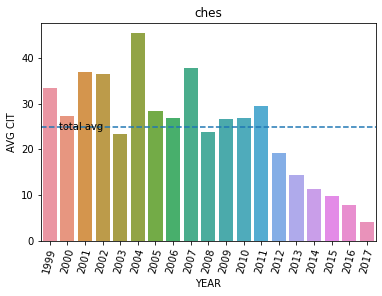

In [24]:
#Stampo i grafici di alcune conferenze tra le più alte citazioni medie     
for key in top10_conference_by_avgCit.keys():
    #Controllo che ci siano stati un numero minino di edizioni, perché il grafico ha senso se possiamo paragonare 
    #diverse edizioni della stessa conferenza
    if(df_conf_evolution.at[key,'n_editions']>5):
        plt.figure(key)
        draw_avg_cit_graph(key)

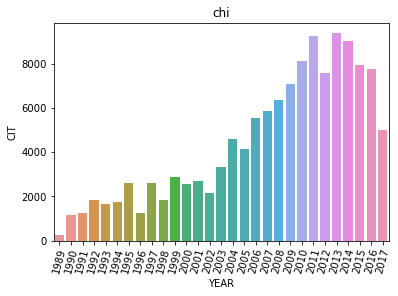

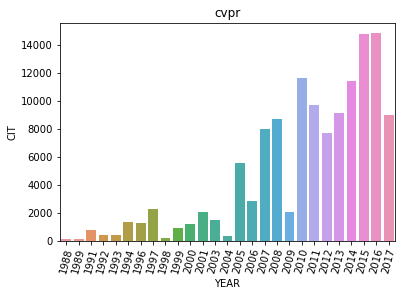

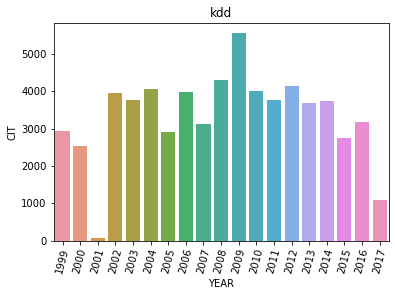

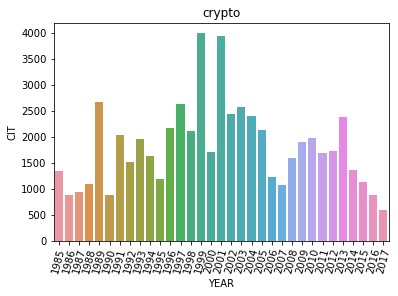

In [25]:
#Stampo i grafici con l'andamento delle citazioni totali negli anni delle 5 conferenze che hanno accomulato più citazioni 
for key in list(top10_conference_by_cit.keys())[0:4]:
    plt.figure(key)
    draw_tot_cit_graph(key)

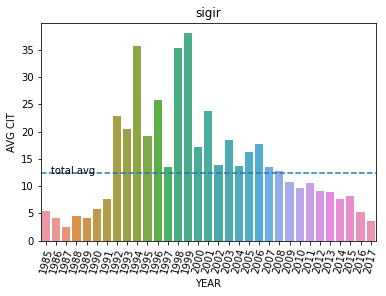

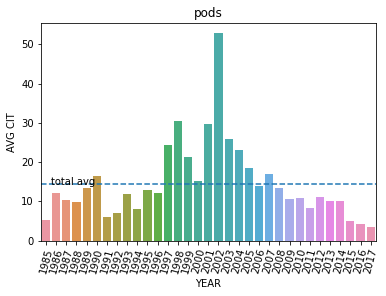

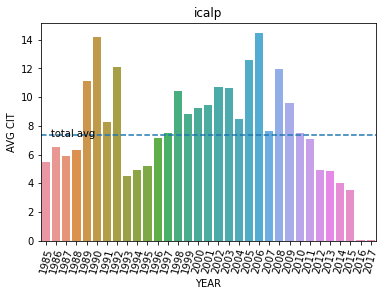

In [26]:
#Stampo i grafici delle conferenze che si sono tenute più volte 
for key in list(top10_num_editions.keys())[0:3]:
    plt.figure(key)
    draw_avg_cit_graph(key)

In [27]:
#Possiamo fare diverse osservazioni guardando questi grafici:
#innanzitutto possiamo subito notare che ci sono spesso grandi differenze tra un anno e l'altro ed è proprio grazie 
#a questi grafici che possiamo individuare quali anni e conferenze prendere in considerazione per lo studio dei dati 
#turistici/geografici
#Un altra osservazione che possiamo fare è che forse il 2017 è troppo recente per essere preso in considerazione
#Potrebbe essere interessante e utile analizzare i grafici di quelle conferenze che hanno grandi differenze di 
#citazioni tra un anno e l'altro

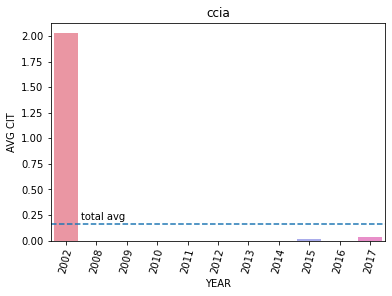

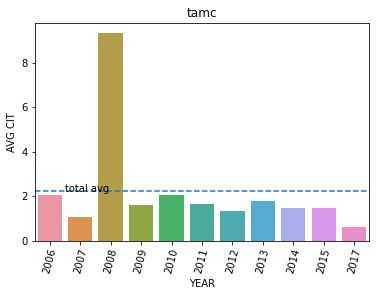

In [28]:
#Altre conferenze che può essere utile analizzare tramite grafico sono quelle con alta percentuale di edizioni sotto
#la media totale
for row,col in list(df_over_and_under_avg_cit.iterrows())[1:3]:
    plt.figure(row)
    draw_avg_cit_graph(row)

In [29]:
#Creo un dataframe dove per ogni conferenza mi segno l'anno con più citazioni, l'anno con meno citazioni, l'anno con più 
#citazioni medie e quello con meno citazioni medie


#Anno con meno citazioni medue
year_with_min_avg_cit = {k:v for k,v in avg_cit_evolution.idxmin(axis=1).items()}
df_year_with_min_avg_cit = pd.DataFrame(data=year_with_min_avg_cit.values(), index=year_with_min_avg_cit.keys(), columns=['MIN AVG-year'])

#oltre all'anno individuo anche il valore 
min_avg_cit = {k:v for k,v in avg_cit_evolution.min(axis=1).items()}
df_min_avg_cit = pd.DataFrame(data=min_avg_cit.values(), index=min_avg_cit.keys(), columns=['MIN AVG-value'])

#Anno con meno citazioni totali
year_with_min_cit = {k:v for k,v in cit_evolution.idxmin(axis=1).items()}
df_year_with_min_cit = pd.DataFrame(data=year_with_min_cit.values(), index=year_with_min_cit.keys(), columns=['MIN CIT-year'])

#valore
min_cit = {k:v for k,v in cit_evolution.min(axis=1).items()}
df_min_cit = pd.DataFrame(data=min_cit.values(), index=min_cit.keys(), columns=['MIN CIT-value'])


#Anno con più citazioni medie 
year_with_max_avg_cit = {k:v for k,v in avg_cit_evolution.idxmax(axis=1).items()}
df_year_with_max_avg_cit = pd.DataFrame(data=year_with_max_avg_cit.values(), index=year_with_max_avg_cit.keys(), columns=['MAX AVG-year'])

#valore
max_avg_cit = {k:v for k,v in avg_cit_evolution.max(axis=1).items()}
df_max_avg_cit = pd.DataFrame(data=max_avg_cit.values(), index=max_avg_cit.keys(), columns=['MAX AVG-value'])

#Anno con più citazioni totali
year_with_max_cit = {k:v for k,v in cit_evolution.idxmax(axis=1).items()}
df_year_with_max_cit = pd.DataFrame(data=year_with_max_cit.values(), index=year_with_max_cit.keys(), columns=['MAX CIT-year'])

#valore
max_cit = {k:v for k,v in cit_evolution.max(axis=1).items()}
df_max_cit = pd.DataFrame(data=max_cit.values(), index=max_cit.keys(), columns=['MAX CIT-value'])

#Calcolo differenza tra min e max
dif_cit = {k:(max_cit[k]-v)  for k,v in min_cit.items()}
df_dif_cit = pd.DataFrame(data=dif_cit.values(), index=dif_cit.keys(), columns=['DIF CIT'])
dif_avg_cit = {k:(max_avg_cit[k]-v)  for k,v in min_avg_cit.items()}
df_dif_avg_cit = pd.DataFrame(data=dif_avg_cit.values(), index=dif_avg_cit.keys(), columns=['DIF AVG CIT'])

#Unisco tuti i  dataframe creati 
df_min_max = pd.concat([df_year_with_min_avg_cit, df_min_avg_cit, df_year_with_max_avg_cit, df_max_avg_cit, 
                       df_year_with_min_cit, df_min_cit, df_year_with_max_cit, df_max_cit, df_dif_avg_cit, df_dif_cit],axis=1)
df_min_max = df_min_max.sort_values(['DIF AVG CIT'], ascending=False)
df_min_max.head(10)

,MIN AVG-year,MIN AVG-value,MAX AVG-year,MAX AVG-value,MIN CIT-year,MIN CIT-value,MAX CIT-year,MAX CIT-value,DIF AVG CIT,DIF CIT
cscw,1986,4.142857,2000,162.903846,1986,145.0,2000,8471.0,158.760989,8326.0
mobicom,2017,1.237374,2000,127.357143,1996,156.0,2000,3566.0,126.119769,3410.0
wmcsa,2006,0.458333,1999,119.083333,2006,11.0,1999,1429.0,118.625000,1418.0
crypto,2017,8.194444,2001,119.606061,2017,590.0,1999,3995.0,111.411616,3405.0
eurocrypt,1985,5.468750,2005,115.272727,1985,175.0,2004,3935.0,109.803977,3760.0
sigcomm,1985,0.815789,2001,98.521739,1985,31.0,2013,2346.0,97.705950,2315.0
sosp,2017,5.631579,2003,82.045455,1985,141.0,2003,1805.0,76.413876,1664.0
middleware,2017,1.178082,2001,64.150000,2016,81.0,2001,1283.0,62.971918,1202.0
ecoop,2017,0.240000,1997,61.521739,2017,12.0,1997,1415.0,61.281739,1403.0
ccs,2017,3.049661,1993,62.566667,1994,275.0,2013,3726.0,59.517005,3451.0


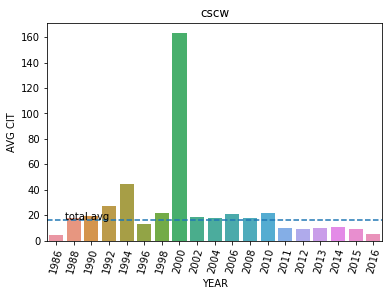

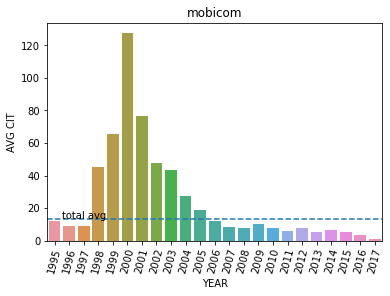

In [30]:
#Stampo il grafico dell'andamento delle citazioni medie negli anni delle prime 4 conferenze con maggior differenza tra 
#anno migliore e peggiore 
for row,col in list(df_min_max.head(10).iterrows())[0:2]:
    plt.figure(row)
    draw_avg_cit_graph(row)


In [31]:
#Per non rendere troppo pesante il documento ho riportato solo qualche esempio di conferenze che si possono estrarre
#dai vari datafrme creati. Una volta scelta con cura una serie di conferenze da analizzare, che possono essere per 
#esempio quelle con più alte citazioni medie, citazioni totali, numero di edizioni, o con alta percentuale di 
#conferenze sotto la media totale, possiamo analizzare a parte il grafico di ognuna di queste conferenze per individuare
#gli anni in cui le citazioni sono stati molto al di sopra della media o molto al di sotto e capire se il luogo incide.

In [32]:
#creo un dataframe dove per ogni conferenza calcolo il rapporto tra citazioni medie di quell'anno e le citazioni medie totali
lst_dataframes = []
for conference in keys:
    single_conference = {}
    n_editions = 0
    for k,v in conference_tot_cit[conference].items():
        avg_cit = v/conference_tot_article[conference][k]
        if(df_conf_evolution.at[conference,'avg_cit']!=0):
            single_conference[k] = avg_cit/df_conf_evolution.at[conference,'avg_cit']
        else:
            single_conference[k] = 0
        n_editions +=1
    single_conference['tot avg'] = df_conf_evolution.at[conference,'avg_cit']
    #creo una lista di dataframe, ogni dataframe corrisponde ad una conferenza
    #Siccome questo dataframe ha lo scopo di analizzare l'evoluzione di una conferenza si possono eliinare tutte le conferenze 
    #che si sono tenute una sola volta
    if n_editions>1:
        lst_dataframes.append(pd.DataFrame(data=[single_conference.values()], index = [conference], columns=single_conference.keys()))
#unisco tutti i dataframe creati
df_ratio = pd.concat(lst_dataframes)
#ordino le colonne in ordine alfabetico
df_ratio = df_ratio.reindex(sorted(df_ratio.columns), axis=1)
df_ratio.head(10)

,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,tot avg
3dic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.848580,1.310994,0.534109,NaN,0.855534,0.551758,0.432628,0.144209,NaN,0.866795
3dica,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.634925,1.538975,1.041411,0.470315,0.145798,0.145798,NaN,NaN,1.371765
3dim,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.280777,1.269640,2.052426,0.579134,0.433448,1.884413,0.476001,2.992974
3dor,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,2.571429,0.000000,1.542857,0.000000,1.051948,1.542857,2.571429,0.043210
3dpvt,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.202439
3dtv,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.236559,1.151279,1.125066,0.728687,0.850134,0.538502,0.539130
3dui,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.201727,1.692183,1.077837,1.115004,0.814130,1.214116,0.597324,0.892003,0.816526,2.242144
3pgcic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.395894,1.367707,1.228840,1.855162,0.852377,0.732026,0.328446,0.289988,0.785714
ACISicis,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.108091,1.248697,1.187608,0.863367,0.764844,0.772946,0.881628,0.815196,0.700743,0.779191
ACMace,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.744110,0.737765,1.315083,0.750821,0.759665,0.918875,0.555400,0.404677,0.231333,2.564356


In [33]:
#Implemento una funzione che dato in input un link di una conferenze mi estrae il luogo dove si è tenuta
if no_exe:
    def get_place(link):
        html = urlopen(link)
        bsh = BeautifulSoup(html.read(), 'html.parser').h1
        try:
            return str(bsh).split(':')[1].split('<')[0]
        except:
            return None

In [34]:
#Chiamo la funzione get_place per ogni singola conferenza
if no_exe:
    link = 'https://dblp.org/db/'
    d = {}
    for x in list(df_single_conference.index.values):
        try:
            s = str(x).split('/')
            url = link + s[0] + '/' + s[1] + '/' + s[1]+s[2] + '.html'
        except:
            pass
        try:
            d[x] = get_place(url)
        except:
            d[x] = None

In [35]:
#Pulisco il contenuto estratto e creo un dataframe
if no_exe:
    for k,v in d.items():
        d[k]=str(v).strip()
    df_place_of_conference1= pd.DataFrame(data=d.values(), index=d.keys(), columns=['Place'])
    df_place_of_conference1.to_csv(path_file+'\place_of_conference1.csv')

In [36]:
#In questo modo sono riuscito ad estrarre il luogo di 22196 conferenze su 28329. 
#Modificando leggermente il modo in cui compongo l'url posso estrarre altri luoghi delle conferenze che non sono riusciuto
#ad estrarre prima
if no_exe:
    link = 'https://dblp.org/db/'
    d = {}
    place_of_conf = df_place_of_conference1.to_dict()['Place']
    for k,v in place_of_conf.items():
        if v == 'None':
            s = str(k).split('/')
            data = ''
            try:
                for x in range(4):
                    data += s[2][x]
                url = link + s[0] + '/' + s[1] + '/' + s[1]+data + '.html' 
            except:
                pass
            try:
                d[k] = get_place(url)
            except:
                d[k] = None

In [37]:
#In questo modo sono riuscito ad estrarre il luogo di altre 2000 conferenze circa.
#Pulisco i dati e creo un nuovo csv
if no_exe:
    for k,v in d.items():
        d[k]=str(v).strip()
    df_place = pd.DataFrame(data=d.values(), index=d.keys(), columns=['Place'])
    df_place.to_csv(path_file+'\out.csv')

In [38]:
#Creo un nuovo dataframe aggiungendo anche i dati appena estratti
if no_exe:
    for k,v in d.items():
        if v != 'None':
            place_of_conf[k]=v
    df_place = pd.DataFrame(data=place_of_conf.values(), index=place_of_conf.keys(), columns=['Place'])
    df_place.to_csv(path_file+'\place_of_conference.csv')

In [39]:
#Apro il dataframe conferenza/luogo
df_place_of_conf = pd.read_csv(path_file + '/place_of_conference.csv').set_index('crossref')
df_place_of_conf.head(10)

,city,state,other,cod
crossref,,,,
conf/cscw/2000,Philadelphia,USA,PA,cscw
conf/mobicom/2000,Boston,USA,MA,mobicom
conf/crypto/2001,Santa Barbara,USA,CA,crypto
conf/wmcsa/1999,New Orleans,USA,LA,wmcsa
conf/eurocrypt/2005,Aarhus,Denmark,NaN,eurocrypt
conf/eurocrypt/2004,Interlaken,Switzerland,NaN,eurocrypt
conf/crypto/1999,Santa Barbara,USA,CA,crypto
conf/sigcomm/2001,San Diego,USA,CA,sigcomm
conf/adaptive/2007,Paris,France,NaN,adaptive


In [40]:
#Unisco i dataframe per avere citazioni medie, totali e luoghi nello stesso dataframe
df_single_conference_whit_place = pd.concat([df_single_conference, df_place_of_conf],axis=1)
df_single_conference_whit_place.head(10)

,CIT TOT,CIT AVG,N.ARTICLES,city,state,other,cod
conf/cscw/2000,8471.0,162.903846,52.0,Philadelphia,USA,PA,cscw
conf/mobicom/2000,3566.0,127.357143,28.0,Boston,USA,MA,mobicom
conf/crypto/2001,3947.0,119.606061,33.0,Santa Barbara,USA,CA,crypto
conf/wmcsa/1999,1429.0,119.083333,12.0,New Orleans,USA,LA,wmcsa
conf/eurocrypt/2005,3804.0,115.272727,33.0,Aarhus,Denmark,NaN,eurocrypt
conf/eurocrypt/2004,3935.0,109.305556,36.0,Interlaken,Switzerland,NaN,eurocrypt
conf/crypto/1999,3995.0,102.435897,39.0,Santa Barbara,USA,CA,crypto
conf/sigcomm/2001,2266.0,98.521739,23.0,San Diego,USA,CA,sigcomm
conf/adaptive/2007,2074.0,86.416667,24.0,Paris,France,NaN,adaptive
conf/sosp/2003,1805.0,82.045455,22.0,Hudson River,USA,NY,sosp


In [41]:
#Raggruppo e calcolo le citazioni medie, totali e numero di edizioni per ogni singola città
df_sum_cit_by_place = df_single_conference_whit_place.groupby('city')['CIT TOT'].sum()
df_count_cit_by_place = df_single_conference_whit_place.groupby('city')['city'].count()
df_mean_cit_by_place = df_single_conference_whit_place.groupby('city')['CIT TOT'].mean()
dict_cit_by_city = {}
for k,v in df_sum_cit_by_place.items():
    if not(k == 'None'):
        dict_cit_by_city[k] = [df_mean_cit_by_place[k], v, df_count_cit_by_place[k]]
dict_cit_by_city = {k: v for k, v in sorted(dict_cit_by_city.items(), key=lambda item: item[1], reverse=True)}
df_cit_by_city = pd.DataFrame(data = dict_cit_by_city.values(), index = dict_cit_by_city.keys(), columns = ['avg cit', 'tot cit', 'editions'])
df_cit_by_city = df_cit_by_city.sort_values('editions', ascending=False)
df_cit_by_city.head(10)

,avg cit,tot cit,editions
Beijing,168.700272,61913.0,368
Paris,190.335366,62430.0,328
San Francisco,274.260870,82004.0,299
Barcelona,203.893130,53420.0,262
London,128.918605,33261.0,258
Vienna,150.299213,38176.0,255
San Jose,217.641434,54628.0,251
Singapore,140.145833,33635.0,240
San Diego,291.093617,68407.0,235
Vancouver,238.300429,55524.0,234


In [42]:
#Metodo per estrarre la dimensione della pagina wikipedia di un città 
if no_exe:
    size_wikipedia_page = {}
    for city in list(df_cit_by_city.index.values):
        if city not in dict_swp.keys():
            page = requests.head('https://en.wikipedia.org/wiki/'+ city)
            c=0
            while page.headers.get ( "content-length" ) == None:
                if c<4:
                    page = requests.head('https://en.wikipedia.org/wiki/'+ city)
                else: 
                    break
                c+=1
            size_wikipedia_page[city]= page.headers.get("content-length")
        else:
            size_wikipedia_page[city]= dict_swp[city]

    df_swp = pd.DataFrame(data = size_wikipedia_page.values(), index = size_wikipedia_page.keys(), columns = ['swp'])
    df_avg_cit_by_place = pd.concat([swp, df_swp],axis=1).set_index('city')
    df_avg_cit_by_place.to_csv(path_file +'/swp.csv')

In [43]:
#Faccio lo stesso sostituendo lo spazio con l'underscore in questo modo estraggo la dimensione delle pagine di quelle città
#che non sono riuscito ad estrarre col primo ciclo
#Alla fine salvo tutto su in file csv 
if no_exe:
    for city,v in size_wikipedia_page.items():
            if v == '0' or v==None:
                url_name = city.replace(' ','_')
                page = requests.head('https://en.wikipedia.org/wiki/'+ url_name)
                c=0
                while page.headers.get ( "content-length" ) == None:
                    if c<2:
                        page = requests.head('https://en.wikipedia.org/wiki/'+ url_name)
                    else: 
                        break
                    c+=1
                size_wikipedia_page[city] = page.headers.get("content-length")
    swp2 = pd.DataFrame(data = size_wikipedia_page.values(), index = size_wikipedia_page.keys(), columns = ['swp'])
    swp2.to_csv(path_file + '/swp.csv')

In [44]:
#Importo csv con dimensione della pagina wikipedia di diverse città calcolate in precedenza e file csv con numero di turisti per
#le top 100 città.
#Nel calcolo del coefficiente di correlazione non tengo conto delle città dove si è tenuta una sola conferenza  
dict_swp = pd.read_csv(path_file + '/swp.csv').set_index('city').to_dict()['swp']
df_swp = pd.DataFrame(data = dict_swp.values(), index = dict_swp.keys(), columns = ['swp'])

dict_tourist = pd.read_csv(path_file + '/city/city_tourist.csv').set_index('City').to_dict()['Arrivals(Millions)']
df_tourist = pd.DataFrame(data = dict_tourist.values(), index = dict_tourist.keys(), columns = ['tourist'])

df_cit_and_swp = pd.concat([df_cit_by_city, df_swp], axis=1).dropna()
df_cit_and_swp = pd.concat([df_cit_and_swp, df_tourist], axis=1)

df_cit_and_swp = df_cit_and_swp[df_cit_and_swp['editions']>1]
df_cit_and_swp.head(10)

,avg cit,tot cit,editions,swp,tourist
Beijing,168.700272,61913.0,368.0,179383.0,4.00
Paris,190.335366,62430.0,328.0,218583.0,17.56
San Francisco,274.260870,82004.0,299.0,177857.0,2.90
Barcelona,203.893130,53420.0,262.0,135424.0,6.71
London,128.918605,33261.0,258.0,199587.0,19.23
Vienna,150.299213,38176.0,255.0,120905.0,6.41
San Jose,217.641434,54628.0,251.0,16455.0,NaN
Singapore,140.145833,33635.0,240.0,195753.0,18.55
San Diego,291.093617,68407.0,235.0,140344.0,NaN
Vancouver,238.300429,55524.0,234.0,137443.0,3.21


In [45]:
#Definisco le funzioni per calcolare il p-value per ogni metodo di correlazione utilizzato
def kendall_pval(x,y):
    return stats.kendalltau(x,y)[1]

def pearsonr_pval(x,y):
    return stats.pearsonr(x,y)[1]

def spearmanr_pval(x,y):
    return stats.spearmanr(x,y)[1]

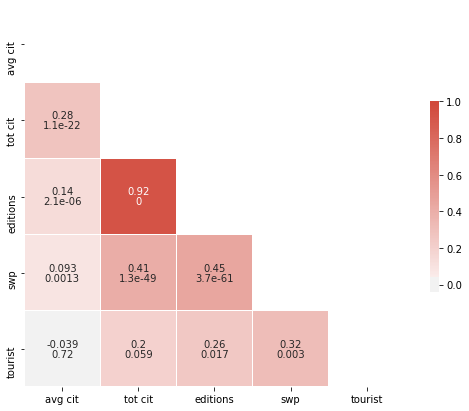

In [46]:
#Calcolo il coefficente di correlazione e p-value utilizzando tre diverse funzioni: pearson, kendall e spearman.
corr_pearson = df_cit_and_swp.corr(method= 'pearson')
p_value = df_cit_and_swp.corr(method= pearsonr_pval)

mask = np.triu(np.ones_like(corr_pearson, dtype=float))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(9, 7))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 15, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_pearson, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, annot_kws = {'va': 'bottom'})

sns.heatmap(corr_pearson, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar = False, annot = p_value, annot_kws = {'va': 'top'})

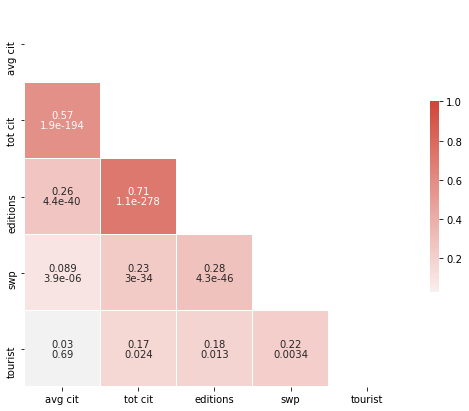

In [47]:
#Ricalcolo il coefficiente di correlazione con il metodo kendall 
corr_kendall = df_cit_and_swp.corr(method= 'kendall')
p_value = df_cit_and_swp.corr(method = kendall_pval)

mask = np.triu(np.ones_like(corr_kendall, dtype=float))
f, ax = plt.subplots(figsize=(9, 7))
cmap = sns.diverging_palette(230, 15, as_cmap=True)

sns.heatmap(corr_kendall, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, annot_kws = {'va':'bottom'})

sns.heatmap(corr_kendall, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar = False, annot=p_value, annot_kws = {'va':'top'})

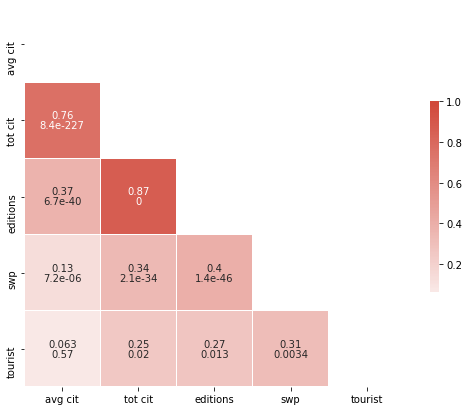

In [48]:
#Ricalcolo il coefficiente di correlazione con il metodo spearman
corr_spearman = df_cit_and_swp.corr(method= 'spearman')
p_value = df_cit_and_swp.corr(method = spearmanr_pval)

mask = np.triu(np.ones_like(corr_spearman, dtype=float))
f, ax = plt.subplots(figsize=(9, 7))
cmap = sns.diverging_palette(230, 15, as_cmap=True)

sns.heatmap(corr_spearman, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, annot_kws = {'va':'bottom'})

sns.heatmap(corr_spearman, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar = False, annot=p_value, annot_kws = {'va':'top'})

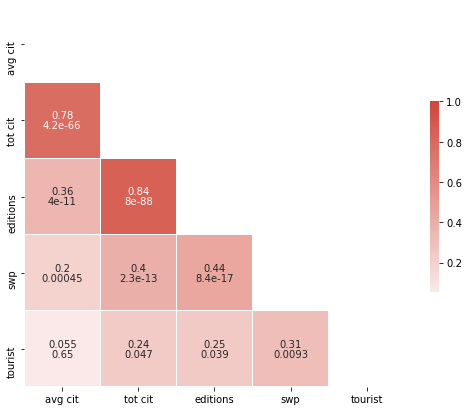

In [49]:
#Se andiamo a considerare solo i luoghi dove si sono tenute più di un tot di edizioni, il coefficiente correlazione tra 
#le citazioni medie e la dimensione delle pagine wikipedia aumenta 
df_for_corr = df_cit_and_swp[df_cit_and_swp['editions']>14]
corr_spearman = df_for_corr.corr(method= 'spearman')
p_value = df_for_corr.corr(method = spearmanr_pval)

mask = np.triu(np.ones_like(corr_spearman, dtype=float))
f, ax = plt.subplots(figsize=(9, 7))
cmap = sns.diverging_palette(230, 15, as_cmap=True)

sns.heatmap(corr_spearman, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, annot_kws = {'va':'bottom'})
sns.heatmap(corr_spearman, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar = False, annot=p_value, annot_kws = {'va':'top'})

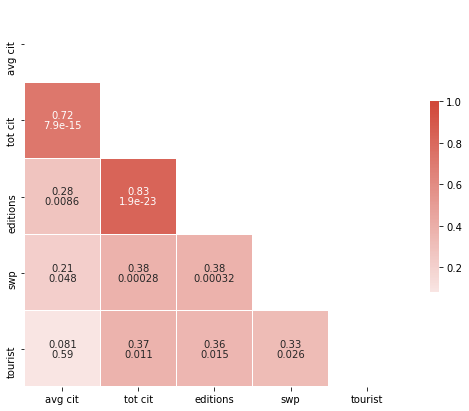

In [50]:
df_for_corr = df_cit_and_swp[df_cit_and_swp['editions']>57]
corr_spearman = df_for_corr.corr(method= 'spearman')
p_value = df_for_corr.corr(method= spearmanr_pval)

mask = np.triu(np.ones_like(corr_spearman, dtype=float))
f, ax = plt.subplots(figsize=(9, 7))
cmap = sns.diverging_palette(230, 15, as_cmap=True)

sns.heatmap(corr_spearman, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, annot_kws = {'va':'bottom'})
sns.heatmap(corr_spearman, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar = False, annot=p_value, annot_kws = {'va':'top'})

La prima cosa che possiamo dire osservando il p-value (sempre minore di 0,05) è che i dati osservati sono statisticamente significativi.
La seconda cosa che salta subito all'occhio è che il coefficiente di correlazione cresce al aumentare della soglia minimo di edizioni nelle città per essere considera nel calcolo della correlazione. Infatti, dalla correlazione dei dati, possiamo notare come il numero di conferenze tenute in una città dipende da quanto questa è grande, conosciuta, e turistica ma un alto numero di edizioni va ad impattare sulla qualità media poiché su così tante conferenze qualcuna sicuramente ha reso al di sotto delle aspettative. Osservando il dataframe ordinato per citazioni medie possiamo notare come nelle prime posizione troviamo città in cui si sono tenute poche conferenze, in media 3 o 4, e a livello di numero di turisti annuali hanno numeri inferiori rispetto a Parigi o Londra per esempio ma non per questo meno attrattive. Parliamo infatti di posti come kauai island, Big Island, Interlaken, Koloa ... che appunto hanno meno turisti perché sono posti più piccole, più difficile da raggiungere e probabilmente più dispendiosi a livello economico ma non sicuramente meno affascinanti. Dunque il coefficiente di correlazione potrebbe essere molto più alto se fosse possibile calcolare per ogni città un indice che tenga conto di tutti questi fattori.

In [51]:
#Raggruppo e calcolo le citazioni medie, totali e numero di edizioni per ogni singola città
df_sum_cit_by_country = df_single_conference_whit_place.groupby('state')['CIT TOT'].sum()
df_count_cit_by_country = df_single_conference_whit_place.groupby('state')['city'].count()
df_mean_cit_by_country = df_single_conference_whit_place.groupby('state')['CIT TOT'].mean()
dict_cit_by_country = {}
for k,v in df_sum_cit_by_country.items():
    if not(k == 'None'):
        dict_cit_by_country[k] = [df_mean_cit_by_country[k], v, df_count_cit_by_country[k]]
dict_cit_by_country = {k: v for k, v in sorted(dict_cit_by_country.items(), key=lambda item: item[1], reverse=True)}
df_cit_by_country = pd.DataFrame(data = dict_cit_by_country.values(), index = dict_cit_by_country.keys(), columns = ['avg cit', 'tot cit', 'editions'])
df_cit_by_country = df_cit_by_country.sort_values('avg cit', ascending=False)

In [52]:
#Leggo il csv con le informazioni sugli stati e lo unisco con il dataframe con le citazioni medie per ogni stato
df_country_index = pd.read_csv(path_file + '/country/country_index.csv').set_index('state')
df_country_index['sum index'] = df_country_index.sum(axis=1)
df_country_index = df_country_index.sort_values('sum index', ascending=False)
df_cit_and_country_index = pd.concat([df_cit_by_country, df_country_index], axis=1).dropna()
df_cit_and_country_index = df_cit_and_country_index.sort_values('editions', ascending=False)
df_cit_and_country_index.head(10)

,avg cit,tot cit,editions,TTCI,TSI,CRBT,GPI,sum index
USA,249.778156,1539133.0,6167.0,5.3,6.6,4.7,4.9,21.5
China,130.448336,223458.0,1714.0,4.9,3.5,7.0,3.9,19.3
Germany,124.612712,168601.0,1356.0,5.4,5.9,6.5,5.7,23.5
Italy,150.486378,187807.0,1252.0,5.1,6.0,6.5,4.7,22.3
France,146.348324,178984.0,1225.0,5.4,5.7,6.8,5.6,23.5
Canada,209.471154,217850.0,1044.0,5.1,6.1,4.0,3.9,19.1
UK,153.199223,157642.0,1029.0,5.2,6.1,5.6,5.4,22.3
Spain,135.636073,127091.0,940.0,5.4,6.6,6.7,5.2,23.9
Japan,137.903664,101635.0,738.0,5.4,5.7,6.5,6.0,23.6
Portugal,99.286765,54012.0,546.0,4.9,6.7,4.1,4.2,19.9


TTCI = Travel & Tourism Competitiveness Index (min 1, max 7)
TSI = Tourist service infrastructure (min 1, max 7)
CRBT = Cultural resources and business travel (min 1, max 7)
GPI = Ground and port infrastructure (min 1, max 7)

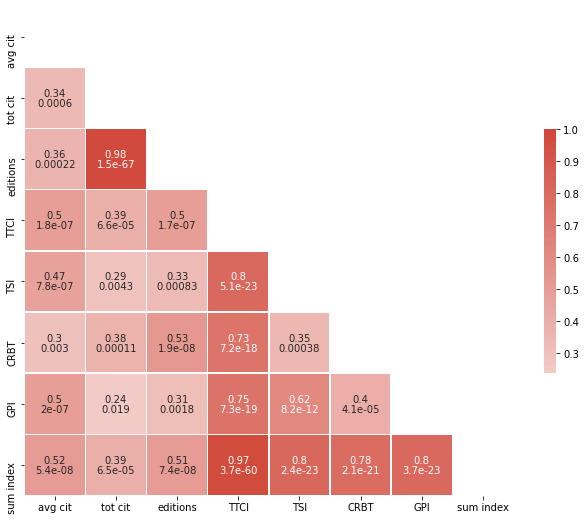

In [53]:
#Calcolo il coefficiente di correlazione con il metodo pearson
corr_pearson = df_cit_and_country_index.corr(method= 'pearson')
p_value = df_cit_and_country_index.corr(method= pearsonr_pval)

mask = np.triu(np.ones_like(corr_pearson, dtype=float))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 15, as_cmap=True)

sns.heatmap(corr_pearson, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True,  annot_kws = {'va':'bottom'})
sns.heatmap(corr_pearson, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar = False, annot=p_value, annot_kws = {'va':'top'})

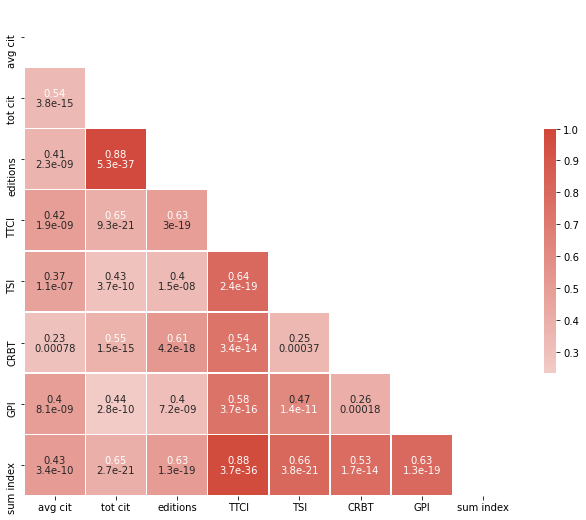

In [54]:
#Calcolo il coefficiente di correlazione con il metodo kendall
corr_kendall = df_cit_and_country_index.corr(method= 'kendall')
p_value = df_cit_and_country_index.corr(method= kendall_pval)

mask = np.triu(np.ones_like(corr_kendall, dtype=float))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 15, as_cmap=True)

sns.heatmap(corr_kendall, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, annot_kws = {'va':'bottom'})
sns.heatmap(corr_pearson, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar = False, annot=p_value, annot_kws = {'va':'top'})

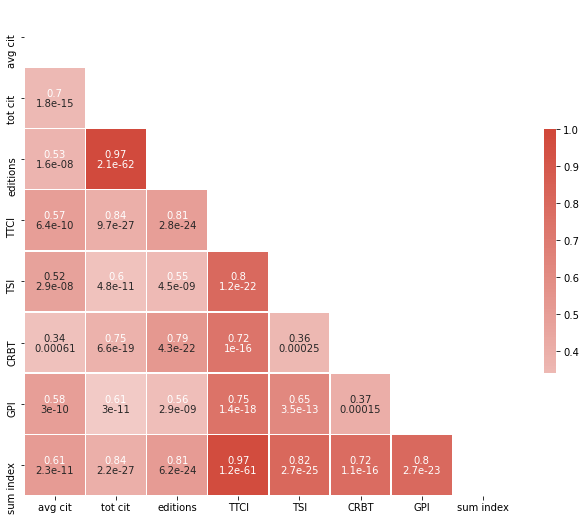

In [55]:
#Calcolo il coefficiente di correlazione con il metodo spearman
corr_spearman = df_cit_and_country_index.corr(method= 'spearman')
p_value = df_cit_and_country_index.corr(method= spearmanr_pval)

mask = np.triu(np.ones_like(corr_spearman, dtype=float))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 15, as_cmap=True)

sns.heatmap(corr_spearman, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, annot_kws = {'va':'bottom'})
sns.heatmap(corr_pearson, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar = False, annot=p_value, annot_kws = {'va':'top'})

Notiamo subito che a livello di stato il coefficiente di correlazione è molto più alto, questo è sicuramente dovuto al fatto che consideriamo aree molto più ampie ma anche perché siamo riusciti a raccogliere dati più significativi per quanto riguarda uno stato cosa che è stata impossibile fare per oltre 2000 città. Sono infatti andato a raccogliere diversi indici per ogni stato e la somma di questi sono un dato rilevante in quanto ci può dire tanto sul livello turistico di un determinato stato. Il p-value è sempre molto basso, possiamo dunque considerare i dati osservati sono statisticamente significativi.

In [56]:
#funzione che per ogni conferenza mi calcola il suo coefficiente di correlazione. In particolare la correlazione viene fatta 
#tra le dimensioni delle pagine wikipedia delle città dove si sono tenute le varie edizioni con le citazioni medie e le 
#citazioni totali.
df_year = pd.read_csv(path_file + '/year.csv').set_index('crossref')
def conference_city_corr(conference):
    d_swp = {}
    d_avg_cit = {}
    d_tot_cit = {}
    d = {}
    for crossref,v in df_place_of_conf.iterrows():
        for column,val in v.items():
            if(val==conference):
                if df_place_of_conf.at[crossref,'city'] in list (df_swp.index.values):
                    d_swp[crossref] = df_swp.at[df_place_of_conf.at[crossref,'city'], 'swp']
                    try:
                        d_avg_cit[crossref] = avg_cit_evolution.at[conference, str(df_year.at[crossref, 'year'])]
                        d_tot_cit[crossref] = cit_evolution.at[conference, str(df_year.at[crossref, 'year'])]
                    except KeyError:
                        d['swp-avg_cit'] = 'ERROR: editions < 2'
                        d['swp-avg_cit_pvalue'] = 'ERROR: editions < 2'
                        d['edtions'] = 1
                        return d
    lst_swp = []
    lst_avg_cit = []
    lst_tot_cit = []
    for k,v in d_swp.items():
        if(v != 'None' and d_avg_cit[k] != 'None' and d_tot_cit[k] != 'None'):
            lst_swp.append(v)
            lst_avg_cit.append(d_avg_cit[k])
            lst_tot_cit.append(d_tot_cit[k])
    if len(lst_swp)<2 and len(lst_avg_cit)<2:
        d['swp-avg_cit'] = 'ERROR: len list < 2'
        d['swp-avg_cit_pvalue'] = 'ERROR: len list < 2'
        d['swp-tot_cit'] = 'ERROR: len list < 2'
        d['swp-tot_cit_pvalue'] = 'ERROR: len list < 2'
        d['edtions'] = len(lst_swp)
    elif lst_swp.count(lst_swp[0]) == len(lst_swp):
        d['swp-avg_cit'] = 'ERROR: An input array is constant'
        d['swp-avg_cit_pvalue'] = 'ERROR: An input array is constant'
        d['swp-tot_cit'] = 'ERROR: An input array is constant'
        d['swp-tot_cit_pvalue'] = 'ERROR: An input array is constant'
        d['edtions'] = len(lst_swp)
    else:
        pearson_avg_cit = stats.spearmanr(lst_swp, lst_avg_cit)
        pearson_tot_cit = stats.spearmanr(lst_swp, lst_tot_cit)
        d['swp-avg_cit'] = pearson_avg_cit[0]
        d['swp-avg_cit_pvalue'] = pearson_avg_cit[1]
        d['swp-tot_cit'] = pearson_tot_cit[0]
        d['swp-tot_cit_pvalue'] = pearson_tot_cit[1]
        d['edtions'] = len(lst_swp)
    return d

In [57]:
#Per ogni conferenze invoco la funzione che mi calcola il coeff. di correlazione e relativo pvalue, infine creo un csv con i
#dati raccolti 
if no_exe:
    d = {}
    for conf in avg_cit_evolution.index.values:
        d[conf] = conference_city_corr(conf) 
    lst = []
    for k,v in d.items():
        val = d[k].values()
        key = d[k].keys()
        lst.append(pd.DataFrame(data = [val], index = [k], columns = key))
    df_conf_corr = pd.concat(lst)
    df_conf_corr.to_csv(path_file + '/corr_city_conf_kendall.csv')

In [58]:
#In questo caso la correlazione viene fatta tra le citazioni medie e totali con la somma degli indici estratti per ogni stato 
#(TTCI, GPI, CRBT, TSI) e il TTCI (Travel & Tourism Competitiveness Index).
def conference_state_corr(conference):
    d = {}
    d_avg_cit = {}
    d_tot_cit = {}
    d_country_ttci = {}
    d_country_index = {}
    for crossref,v in df_place_of_conf.iterrows():
        for column,val in v.items():
            if(val==conference):
                if df_place_of_conf.at[crossref,'state'] in list (df_cit_and_country_index.index.values):
                    d_country_index[crossref] = df_cit_and_country_index.at[df_place_of_conf.at[crossref,'state'], 'sum index']
                    d_country_ttci[crossref] = df_cit_and_country_index.at[df_place_of_conf.at[crossref,'state'], 'TTCI']
                    try:
                        d_avg_cit[crossref] = avg_cit_evolution.at[conference, str(df_year.at[crossref, 'year'])]
                        d_tot_cit[crossref] = cit_evolution.at[conference, str(df_year.at[crossref, 'year'])]
                    except KeyError:
                        d['si-avg_cit'] = 'ERROR: len list < 2'
                        d['si-avg_cit_pvalue'] = 'ERROR: len list < 2'
                        d['si-tot_cit'] = 'ERROR: len list < 2'
                        d['si-tot_cit_pvalue'] = 'ERROR: len list < 2'
                        d['ttci-avg_cit'] = 'ERROR: len list < 2'
                        d['ttci-avg_cit_pvalue'] = 'ERROR: len list < 2'
                        d['ttci-tot_cit'] = 'ERROR: len list < 2'
                        d['ttci-tot_cit_pvalue'] = 'ERROR: len list < 2'
                        d['edtions'] = 1
                        return d
    lst_si = []
    lst_avg_cit = []
    lst_tot_cit = []
    lst_ttci = []
    for k,v in d_country_index.items():
        if(v != 'None' and d_avg_cit[k] != 'None' and d_tot_cit[k] != 'None' and d_country_ttci[k] != 'None'):
            lst_si.append(v)
            lst_ttci.append(d_country_ttci[k])
            lst_avg_cit.append(d_avg_cit[k])
            lst_tot_cit.append(d_tot_cit[k])
    if len(lst_si)<2 or len(lst_avg_cit)<2 or len(lst_ttci)<2:
        d['si-avg_cit'] = 'ERROR: len list < 2'
        d['si-avg_cit_pvalue'] = 'ERROR: len list < 2'
        d['si-tot_cit'] = 'ERROR: len list < 2'
        d['si-tot_cit_pvalue'] = 'ERROR: len list < 2'
        d['ttci-avg_cit'] = 'ERROR: len list < 2'
        d['ttci-avg_cit_pvalue'] = 'ERROR: len list < 2'
        d['ttci-tot_cit'] = 'ERROR: len list < 2'
        d['ttci-tot_cit_pvalue'] = 'ERROR: len list < 2'
        d['edtions'] = len(lst_si)
    elif lst_si.count(lst_si[0]) == len(lst_si):
        d['si-avg_cit'] = 'ERROR: An input array is constant'
        d['si-avg_cit_pvalue'] = 'ERROR: An input array is constant'
        d['si-tot_cit'] = 'ERROR: An input array is constant'
        d['si-tot_cit_pvalue'] = 'ERROR: An input array is constant'
        d['ttci-avg_cit'] = 'ERROR: An input array is constant'
        d['ttci-avg_cit_pvalue'] = 'ERROR: An input array is constant'
        d['ttci-tot_cit'] = 'ERROR: An input array is constant'
        d['ttci-tot_cit_pvalue'] = 'ERROR: An input array is constant'
        d['edtions'] = len(lst_si)
    else:
        si_avg_cit = stats.spearmanr(lst_si, lst_avg_cit)
        si_tot_cit = stats.spearmanr(lst_si, lst_tot_cit)
        ttci_avg_cit = stats.spearmanr(lst_ttci, lst_avg_cit)
        ttci_tot_cit = stats.spearmanr(lst_ttci, lst_tot_cit)
        d['si-avg_cit'] = si_avg_cit[0]
        d['si-avg_cit_pvalue'] = si_avg_cit[1]
        d['si-tot_cit'] = si_tot_cit[0]
        d['si-tot_cit_pvalue'] = si_tot_cit[1]
        d['ttci-avg_cit'] = ttci_avg_cit[0]
        d['ttci-avg_cit_pvalue'] = ttci_avg_cit[1]
        d['ttci-tot_cit'] = ttci_tot_cit[0]
        d['ttci-tot_cit_pvalue'] = ttci_tot_cit[1]
        d['edtions'] = len(lst_si)
    return d

In [59]:
if no_exe:
    print('start')
    c = 0
    conf_state_corr = {}
    conf_city_corr = {}
    for conf in avg_cit_evolution.index.values:
        conf_state_corr[conf] = conference_state_corr(conf)
        conf_city_corr[conf] = conference_city_corr(conf)
        c+=1
        if c%100==0:
            print(c)
    lst = []
    for k,v in conf_state_corr.items():
        val = conf_state_corr[k].values()
        key = conf_state_corr[k].keys()
        lst.append(pd.DataFrame(data = [val], index = [k], columns = key))
    df_conf_state_corr = pd.concat(lst)
    df_conf_state_corr.to_csv(path_file + '/corr_state_conf_spearman.csv')

In [60]:
if no_exe:
    lst = []
    for k,v in conf_city_corr.items():
        val = conf_city_corr[k].values()
        key = conf_city_corr[k].keys()
        lst.append(pd.DataFrame(data = [val], index = [k], columns = key))
    df_conf_corr = pd.concat(lst)
    df_conf_corr.to_csv(path_file + '/corr_city_conf_spearman.csv')

In [61]:
#leggo il csv con il coefficiente di correlazione di ogni conferenza
df_corr_city_conf_pearson = pd.read_csv(path_file + '/corr_city_conf_pearson.csv').set_index('cod')
df_corr_city_conf_pearson

,swp-avg_cit,swp-avg_cit(pvalue),swp-tot_cit,swp-tot_cit(pvalue),edtions
cod,,,,,
3dic,0.399318,0.374825,0.452581,0.307882,7
3dim,0.425876,0.399806,0.395707,0.437420,6
3dor,-0.426333,0.474100,-0.373070,0.536254,5
3dpvt,-0.683446,0.520961,-0.670964,0.531761,3
3dtv,-0.458538,0.360398,-0.048600,0.927157,6
...,...,...,...,...,...
xps,-1.000000,1.000000,-1.000000,1.000000,2
xpu,0.389855,0.516498,-0.813591,0.093864,5
xsede,-0.226593,0.773407,0.661606,0.338394,4


In [62]:
#Calcolo la media per ogni colonna
df_corr_city_conf_pearson.mean()

swp-avg_cit           -0.002455
swp-avg_cit(pvalue)    0.559152
swp-tot_cit           -0.000709
swp-tot_cit(pvalue)    0.546313
edtions                9.483775
dtype: float64

In [63]:
#Per ogni colonna calcolo la media
df_corr_city_conf_pearson.mode()

,swp-avg_cit,swp-avg_cit(pvalue),swp-tot_cit,swp-tot_cit(pvalue),edtions
0,1.0,1.0,-1.0,1.0,2


In [64]:
#leggo il csv con il coefficiente di correlazione di ogni conferenza 
df_corr_state_conf_pearson = pd.read_csv(path_file + '/corr_state_conf_pearson.csv').set_index('cod')
df_corr_state_conf_pearson

,si-avg_cit,si-avg_cit(pvalue),si-tot_cit,si-tot_cit(pvalue),ttci-avg_cit,ttci-avg_cit(pvalue),ttci-tot_cit,ttci-tot_cit(pvalue),edtions
cod,,,,,,,,,
3dic,0.023147,0.960715,0.098767,0.833144,0.147995,0.751498,0.237531,0.608033,7
3dor,0.564030,0.321995,0.469237,0.425262,0.538034,0.349614,0.480384,0.412770,5
3dpvt,0.307003,0.801348,0.290813,0.812148,0.649834,0.549677,0.636847,0.560477,3
3dtv,0.140747,0.790274,-0.371602,0.468254,0.065341,0.902127,-0.409995,0.419467,6
3dui,-0.308158,0.356559,-0.249619,0.459151,-0.308158,0.356559,-0.249619,0.459151,11
...,...,...,...,...,...,...,...,...,...
wwic,0.155977,0.594396,0.207600,0.476362,0.193796,0.506785,0.222298,0.444958,14
www,-0.124704,0.489281,0.115500,0.522134,-0.107324,0.552192,0.102494,0.570319,33
xpu,-0.404797,0.499040,-0.980710,0.003207,-0.404797,0.499040,-0.980710,0.003207,5


In [65]:
#Per ogni colonna calcolo la media 
df_corr_state_conf_pearson.mean()

si-avg_cit              0.014257
si-avg_cit(pvalue)      0.558498
si-tot_cit              0.026391
si-tot_cit(pvalue)      0.547332
ttci-avg_cit            0.014392
ttci-avg_cit(pvalue)    0.553050
ttci-tot_cit            0.023119
ttci-tot_cit(pvalue)    0.542873
edtions                 9.994076
dtype: float64

In [66]:
#Per ogni colonna calcolo la moda
df_corr_state_conf_pearson.mode()

,si-avg_cit,si-avg_cit(pvalue),si-tot_cit,si-tot_cit(pvalue),ttci-avg_cit,ttci-avg_cit(pvalue),ttci-tot_cit,ttci-tot_cit(pvalue),edtions
0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,2


Il pvalue medio è molto alto dunque i dati osservati sono meno significativi rispetto ai dati e grafici ottenuti in precedenza dove avevamo un pvalue con molti zero dopo la virgola e quindi praticamente uguale a 0. 

In [67]:
df_corr_city_conf_kendall = pd.read_csv(path_file + '/corr_city_conf_kendall.csv').set_index('cod')
df_corr_city_conf_kendall

,swp-avg_cit,swp-avg_cit(pvalue),swp-tot_cit,swp-tot_cit(pvalue),edtions
cod,,,,,
3dic,0.205738,0.530495,0.411476,0.209660,7
3dim,0.447214,0.227016,0.447214,0.227016,6
3dor,-0.447214,0.296270,-0.516398,0.248213,5
3dpvt,-0.333333,1.000000,-0.333333,1.000000,3
3dtv,-0.333333,0.469444,-0.276026,0.444217,6
...,...,...,...,...,...
xps,-1.000000,1.000000,-1.000000,1.000000,2
xpu,0.000000,1.000000,-1.000000,0.026888,5
xsede,0.000000,1.000000,0.666667,0.333333,4


In [68]:
df_corr_city_conf_kendall.mean()

swp-avg_cit           -0.206524
swp-avg_cit(pvalue)    0.609878
swp-tot_cit           -0.002459
swp-tot_cit(pvalue)    0.590541
edtions                9.454507
dtype: float64

In [69]:
df_corr_city_conf_kendall.mode()

,swp-avg_cit,swp-avg_cit(pvalue),swp-tot_cit,swp-tot_cit(pvalue),edtions
0,1.0,1.0,-1.0,1.0,2


In [70]:
df_corr_state_conf_kendall = pd.read_csv(path_file + '/corr_state_conf_kendall.csv').set_index('cod')
df_corr_state_conf_kendall

,si-avg_cit,si-avg_cit_pvalue,si-tot_cit,si-tot_cit_pvalue,ttci-avg_cit,ttci-avg_cit_pvalue,ttci-tot_cit,ttci-tot_cit_pvalue,edtions
cod,,,,,,,,,
3dic,-0.158777,0.633839,0.052926,0.873845,-0.056344,0.869417,0.169031,0.621873,7
3dor,0.223607,0.601508,0.258199,0.563703,0.353553,0.420457,0.408248,0.374259,5
3dpvt,-0.333333,1.000000,-0.333333,1.000000,0.333333,1.000000,0.333333,1.000000,3
3dtv,0.200000,0.719444,0.000000,1.000000,0.200000,0.719444,0.000000,1.000000,6
3dui,-0.341121,0.205903,-0.341121,0.205903,-0.341121,0.205903,-0.341121,0.205903,11
...,...,...,...,...,...,...,...,...,...
wwic,-0.079592,0.698682,0.068599,0.739681,0.023739,0.910326,0.155158,0.463512,14
www,0.054224,0.672624,0.090373,0.481278,0.008327,0.949540,0.079109,0.547706,33
xpu,-0.288675,0.542802,-0.866025,0.067889,-0.288675,0.542802,-0.866025,0.067889,5


In [71]:
df_corr_state_conf_kendall.mean()

si-avg_cit             0.005213
si-avg_cit_pvalue      0.577479
si-tot_cit             0.021405
si-tot_cit_pvalue      0.558305
ttci-avg_cit           0.002562
ttci-avg_cit_pvalue    0.554138
ttci-tot_cit           0.020560
ttci-tot_cit_pvalue    0.540976
edtions                9.989774
dtype: float64

In [72]:
df_corr_state_conf_kendall.mode()

,si-avg_cit,si-avg_cit_pvalue,si-tot_cit,si-tot_cit_pvalue,ttci-avg_cit,ttci-avg_cit_pvalue,ttci-tot_cit,ttci-tot_cit_pvalue,edtions
0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,2.0
1,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN


In [73]:
df_corr_city_conf_spearman = pd.read_csv(path_file + '/corr_city_conf_spearman.csv').set_index('cod')
df_corr_city_conf_spearman

,swp-avg_cit,swp-avg_cit_pvalue,swp-tot_cit,swp-tot_cit_pvalue,edtions
cod,,,,,
3dic,0.259437,0.574237,0.370625,0.413116,7
3dim,0.576818,0.230732,0.576818,0.230732,6
3dor,-0.579751,0.305575,-0.577350,0.308068,5
3dpvt,-0.500000,0.666667,-0.500000,0.666667,3
3dtv,-0.542857,0.265703,-0.289886,0.577352,6
...,...,...,...,...,...
xps,-1.000000,NaN,-1.000000,NaN,2
xpu,0.111111,0.858821,-1.000000,0.000000,5
xsede,0.200000,0.800000,0.800000,0.200000,4


In [74]:
df_corr_city_conf_spearman.mean()

swp-avg_cit          -0.004595
swp-avg_cit_pvalue    2.935775
swp-tot_cit          -0.072971
swp-tot_cit_pvalue    1.872372
edtions               9.454507
dtype: float64

In [75]:
df_corr_city_conf_spearman.mode()

,swp-avg_cit,swp-avg_cit_pvalue,swp-tot_cit,swp-tot_cit_pvalue,edtions
0,1.0,0.666667,-1.0,0.666667,2


In [95]:
df_corr_state_conf_spearman = pd.read_csv(path_file + '/corr_state_conf_spearman.csv').set_index('cod')
df_corr_state_conf_spearman

,si-avg_cit,si-avg_cit_pvalue,si-tot_cit,si-tot_cit_pvalue,ttci-avg_cit,ttci-avg_cit_pvalue,ttci-tot_cit,ttci-tot_cit_pvalue,edtions
cod,,,,,,,,,
3dic,-0.243256,0.599144,0.168408,0.718138,-0.115728,0.804848,0.270031,0.558110,7
3dor,0.368932,0.541146,0.288675,0.637618,0.486664,0.405772,0.444262,0.453549,5
3dpvt,-0.500000,0.666667,-0.500000,0.666667,0.500000,0.666667,0.500000,0.666667,3
3dtv,0.314286,0.544093,0.000000,1.000000,0.314286,0.544093,0.000000,1.000000,6
3dui,-0.400000,0.222868,-0.400000,0.222868,-0.400000,0.222868,-0.400000,0.222868,11
...,...,...,...,...,...,...,...,...,...
wwic,-0.117390,0.689401,0.140801,0.631145,0.067510,0.818628,0.247811,0.392986,14
www,0.074882,0.678755,0.101331,0.574725,0.048494,0.788704,0.077420,0.668475,33
xpu,-0.304290,0.618630,-0.912871,0.030466,-0.304290,0.618630,-0.912871,0.030466,5


In [96]:
df_corr_state_conf_spearman.mean()

si-avg_cit             0.004002
si-avg_cit_pvalue      0.927775
si-tot_cit             0.023385
si-tot_cit_pvalue      0.911132
ttci-avg_cit           0.003879
ttci-avg_cit_pvalue    0.480180
ttci-tot_cit           0.022847
ttci-tot_cit_pvalue    0.906288
edtions                9.989774
dtype: float64

In [97]:
df_corr_state_conf_spearman.mode()

,si-avg_cit,si-avg_cit_pvalue,si-tot_cit,si-tot_cit_pvalue,ttci-avg_cit,ttci-avg_cit_pvalue,ttci-tot_cit,ttci-tot_cit_pvalue,edtions
0,1.0,0.666667,1.0,0.666667,1.0,0.666667,1.0,0.333333,2


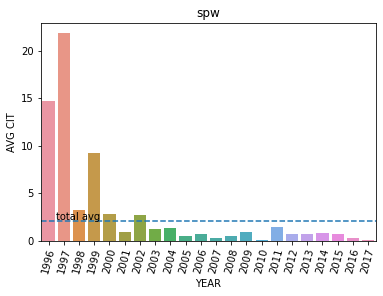

In [79]:
draw_avg_cit_graph('spw')

Osservando l'andamento delle citazioni medie negli anni salta subito all'occhio l'edizione del 1997. Questa edizione si è tenuta a Parigi in Francia ed è una delle poche insieme a quelle del 2007 e 2016 (entrambe a Brno, Czech Republic) che non si sono organizzate a Cambridge, UK. 
La dimensione della pagina wikipedia di queste città sono: 
- Paris: 218583
- Cambridge: 103502
- Brno: 81748

Parigi, tra le tre, è la città più turistica e 'famosa' e infatti l'edizione migliore per citazioni medie si è tenuta proprio in Francia mentre le 2 fatte a Brno sono tra le 4 peggiori. 

(https://dblp.org/db/conf/spw/index.html)

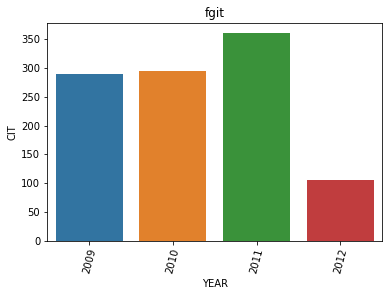

In [80]:
draw_tot_cit_graph('fgit')

La Future Generation Information Technology (FGIT) è un'altra conferenza interessante da analizzare nonostante le poche edizioni. Infatti qui le prime 3 edizioni si sono tenute a Jeju Island in Korea mentre l'ultima è stata organizzata a Gangneug sempre in Korea. Le dimensioni delle pagini wikipedia di queste città sono le seguenti:
- Gangneug 6522
- Jeju Island 43542

Anche in questo caso è evidente come il luogo abbia inciso sulle citazioni totali e quindi sul nostro parametro che misura la qualità di una edizione rispetto a un'altra.

(https://dblp.org/db/conf/fgit/index.html)

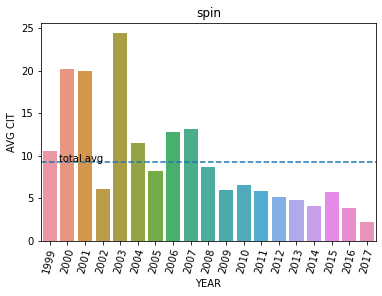

In [81]:
draw_avg_cit_graph('spin')

Analizzando questo grafico notiamo subito le tre migliori edizioni, ovvero le seguenti: 
- 2000: Stanford (115768), CA, USA
- 2001: Toronto (154092), Canada
- 2003: Portland (165786), OR, USA

E' evidente invece come negli ultimi dieci anni sia peggiorata la qualità della conferenza e non a caso anche le città in cui si sono tenute queste conferenze, secondo il nostro parametro, hanno un indice di attrazione minore. Infatti, tralasciando il 2017 che forse è troppo recente e ci può trarre in inganno,  queste sono alcune delle ultime edizioni: 
- 2011: Snowbird (9225), UT, USA
- 2013: Stony Brook (10041), NY, USA
- 2015: Stellenbosch (34508), South Africa
- 2016: Eindhoven (64028), The Netherlands

Un'altra edizione interessante da analizzare è quella del 2002 perché a differenza delle altre che sono peggiorate di qualità nel tempo questa di trova proprio in mezzo tra le due conferenze migliori. Questa edizione infatti si è tenuta a Grenoble in France che ha dimensione della pagina Wikipedia pari a 77023 e quindi quasi la metà rispetto a Toronto e Portland dove la qualità è più che doppia. 
Infine ci sono altre due edizioni che spiccano in mezzo all'altre, ovvero quella del 2006 e 2007 che sono state organizzate respettivamente a Vienna (120905) e Berlino (160847).

(https://dblp.org/db/conf/spin/index.html)

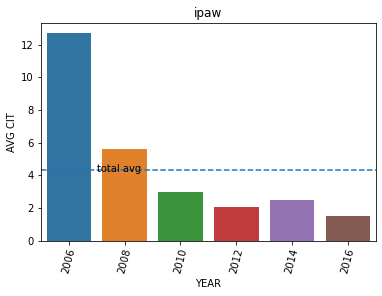

In [82]:
draw_avg_cit_graph('ipaw')

- 2006: Chicago (206303), IL, USA
- 2008: Salt Lake City (140782), UT, USA
- 2010: Troy (135354), NY, USA
- 2012: Santa Barbara (76923), CA, USA
- 2014: Cologne (93960), Germany
- 2016: McLean (15520), VA, USA

Anche in questo caso è evidente come l'edizione nella città più turistica ha nettamente maggior successo rispetto alle altre.

Generalizzando possiamo dire che ogni edizione è leggermente sopra o sotto la media tranne qualcuna che spicca sulle altre in positivo o in negativo. 
Molto spesso l'edizione che ha avuto più successo è nella città con maggior attrazione turistica. In generale nelle città con dimensione della pagina wikipedia (swp) tra i 50.000 e i 120.000 troviamo edizioni che rispettano la media, mentre molto spesso se una delle conferenze si è tenuta in un luogo con swp maggiore di 150.000 questa spicca sulle altre.

Andiamo per esempio ad analizzare la top dieci delle conferenze.

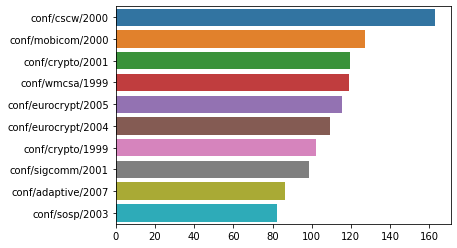

In [83]:
top10_avg_plot = sns.barplot(x=list(top10_avg.values()), y=list(top10_avg.keys()))

- cscw 2000: Philadelphia (177336), Pennsylvania, USA
- mobicom 2000: Boston (162528), Massachusetts, USA 
- crypto 2001: Santa Barbara (76923), California, USA
- wmcsa 1999: New Orleans (149732), LA, USA
- eurocrypt 2005: Aarhus (142233), Denmark
- eurocrypt 2004: Interlaken (46678), Switzerland 
- crypto 1999: Santa Barbara (76923), California, USA
- sigcomm 2001: San Diego (140344), CA, USA 
- sosp 2003: The Sagamore (14928), Bolton Landing (Lake George), New York, USA 
- mobicom 2002: Atlanta (151558), Georgia, USA

Sei delle top dieci conferenze si sono tenute in città con swp maggiore di 140.000, il che non ci stupisce. Per quanto riguarda The Sagamore non è una città ma un resort su un'isola privata nel Lago di George, quindi nonostante il basso swp è sicuramente una meta molto affascinate per un turista. Un discorso simile si può fare per Interlaken, un comune svizzero di 5592 abitanti, quindi non una grande città ma sicuramente affascinate da visitare, inoltre la Svizzara è nella top dieci dei paesi per TTCI (Travel & Tourism Competitiveness Index). 
Infine, tutte le edizioni di crypto, non solo quelle qua sopra, sono state organizzate a Santa Barbara quindi non si può valutare quanto il luogo incida sulla qualità.


Il fatto che crypto, mobicom e eurocrypt compaiano più di una volta nella top dieci significa che l'argomento della conferenza è il fattore principale che determina la qualità media delle varie edizioni. Il luogo può incidere in modo positivo o negativo sulla qualità, ma è praticamente impossibile che una conferenza come 'spin' (analizzata in precedenza) con media citazioni totali di tutte le edizioni intorno al 9 arrivi a toccare 100 o 150 citazioni medie solo perché quell'edizione si è tenuta in una città molto turistica. E' possibile, invece, che l'argomento di una conferenza diventi più interessante, perché magari più di attualità, e quindi può avvere una crescita improvvisa, anche in città meno turistiche rispetto alle precedenti edizioni. Può essere una crescita continua che fa salire da 10 a 100 le citazioni medie in 5/10 anni, oppure è semplicemente un 'boom' di quell'anno. Ovviamente può succedere anche il contrario, cioè che un argomento perda d'interesse. Un esempio può essere crypto che nonostante venga organizzata sempre a Santa Barbara, in California, presenta diverse differenza tra le edizioni dal 1996 al 2005 rispetto alle altre.

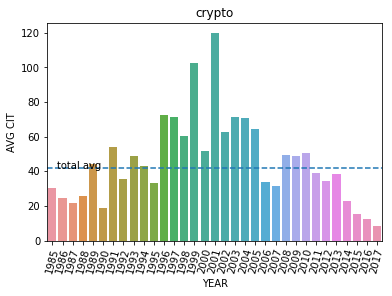

In [84]:
draw_avg_cit_graph('crypto')

In precedenza avevamo preparato un dataframe con il rapporto tra le citazioni medie totali e le citazioni medie per ogni anno. Questo ci permette di inidviduare le edizioni che hanno superato le aspettative. Abbiamo visto come quasi tutte le conferenze hanno almeno un edizioni che spicca sulle altre in quanto le citazioni medie di quell'anno sono 2 o 3 volte le citazioni medie totali. Proviamo però ad estrarre quelle edizioni con un rapporto maggiore di 10. Se quello che abbiamo detto fino a ora è vero ci aspettiamo innanzittutto che siano poche le edizioni con un rapporto maggiore di 10 e dopodiché ci aspettiamo che queste conferenze siano in città con swp >= di 150.000 e/o in uno stato con TTCI >= 5. 

In [85]:
dict_ratio = df_ratio.to_dict()
for k,v in dict_ratio.items():
    for k2,v2 in v.items():
        if v2>=10 and k != 'tot avg':
            print(k2,k)

ispw 1985
sigdoc 1986
ecai 1996
spw 1997
wmcsa 1999
cscw 2000
siggraph 2000
middleware 2001
siggraph 2001
ccia 2002
egve 2006
sbm 2013


12 edizioni su circa 30000 hanno un rapparto tra citazioni medie totali e citazioni medie annuale meggiore di 10, quindi lo 0,04% ed è più o meno quello che mi aspettavo. Passiamo dunque al punto successivo e analizziamo il luogo di queste 12 conferenze.

- ispw 1985: Coto de Caza (31685), Trabuco Canyon, CA (198721), USA 
- sigdoc 1986: Toronto (154092), Ontario, Canada
- ecai 1996: Budapest (161834), Hungary
- spw 1997: Paris (218583), France
- wmcsa 1999: New Orleans (149732), LA (156569), USA
- cscw 2000:  Philadelphia (177336), Pennsylvania, USA
- siggraph 2000: New Orleans (149732), LA (156569), USA
- middleware 2001: Heidelberg (71906), Germany
- siggraph 2001: Los Angeles (146569), CA (198721), USA 
- ccia 2002: Castellón (9951), Spain 
- egve 2006: Lisbon (116666), Portugal
- sbm 2013: Anaheim (7892), CA (198721), USA


Top 12 stati per TTCI (Travel & Tourism Competitiveness Index)
- 1	Spain 5,4
- 2 France 5,4
- 3	Germany 5,4
- 4	Japan 5,4
- 5	United States 5,3
- 6	United Kingdom 5,2
- 7	Australia 5,1
- 8	Italy 5,1
- 9	Canada 5,1
- 10 Switzerland 5
- 11 Austria 5
- 12 Portugal 4,9


Anche in questo caso il risultato è quello che ci aspettavamo, infatti praticamente tutte le 12 conferenze prese in considerazione si sono tenute o in grandi città turistiche o in uno stato con un alto TTCI.
Inoltre il parametro utilizzato per valutare un città non è sempre preciso, infatti luoghi come Anaheim, dove si trova il Disneyland Resort, il grande parco a tema Disney, possono essere molto attrenti dal punto di vista turistico nonostante il suo basso swp. Stesso discorso vale per Coto de Caza. Entrambi comunque si trovano in California, che ha un swp pari a 198721, ed è uno degli stati più gettonati degli stati uniti. 

Un'altra idea può essere quella di confrontare l'edizione migliore e l'edizione peggiore di alcune conferenze. 
In precendeza avevo preparato un dataframe con l'anno dell'edizione migliore e peggiore e ora possiamo prendere le prime 5 conferenze per differenza tra numero massimo di media citazioni e numero minimo e analizzale.
Ci aspettiamo che prima che l'edizione migliore si tenga in un posto più turistisco rispetto alla peggiore. Attezione però non ci dobbiamo per forza aspettare che l'edizione peggiore sia in un posto con basso swp, questo è vero in parecchi casi ma non sempre.

In [86]:
df_min_max.head(5)

,MIN AVG-year,MIN AVG-value,MAX AVG-year,MAX AVG-value,MIN CIT-year,MIN CIT-value,MAX CIT-year,MAX CIT-value,DIF AVG CIT,DIF CIT
cscw,1986,4.142857,2000,162.903846,1986,145.0,2000,8471.0,158.760989,8326.0
mobicom,2017,1.237374,2000,127.357143,1996,156.0,2000,3566.0,126.119769,3410.0
wmcsa,2006,0.458333,1999,119.083333,2006,11.0,1999,1429.0,118.625000,1418.0
crypto,2017,8.194444,2001,119.606061,2017,590.0,1999,3995.0,111.411616,3405.0
eurocrypt,1985,5.468750,2005,115.272727,1985,175.0,2004,3935.0,109.803977,3760.0


CSCW:
 - 1986: Austin (163678), TX, USA
 - 2000: Philadelphia (177336), Pennsylvania, USA
MOBICOM:
 - 2017: Snowbird (9225), UT, USA
 - 2000: Boston (162528), Massachusetts, USA
WMCSA:
 - 2006: Semiahamoo Resort (13031), Washington, USA
 - 1999: New Orleans (149732), LA, USA
CRYPTO:
 - 2017: Santa Barbara (76923), CA, USA
 - 2001: Santa Barbara (76923), CA, USA
EUROCRYPT:
 - 1985: Linz (76898), Austria
 - 2005: Aarhus (142233), Denmark
 
Osservando i risultati si possono notare due cose:
 - ci sono esempi come MOBICOM, WMCSA, EUROCRYPT che confermano la nostra tesi;
 - CSCW e CRYPTO invece sono due esempi di come a distanza di 15 anni un argomento può ossere più o meno d'attualità, questa può    essere una possibile spiegazione della la grande differenza di citazioni nonostante il luogo non cambi o cambi ma resti          comunque una città con un alto livello turistico. 
 

Ora come fatto in precedenza andiamo ad analizzare il grafico di alcune conferenze sta volta però ci concentriamo sullo stato in cui si sono tenute e non la città.

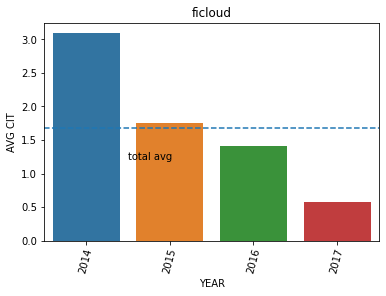

In [87]:
draw_avg_cit_graph('ficloud')

- 2014: Spain 5,4
- 2015: Italy 5,1
- 2016: Austria 5 
- 2017: Czech Republic 4,3 

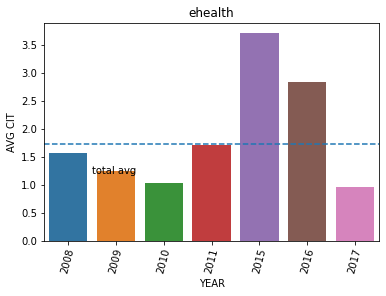

In [88]:
draw_avg_cit_graph('ehealth')

Andiamo a prendere i due anni migliori e i due peggiori, escludendo il 2017 perché è troppo recente.

- 2009: Turkey 4,2
- 2010: Morocco 3,9
- 2015: Italy 5,1
- 2016: Canada 5,1

In entrambi i casi le citazioni medie si alzano nei paesi con un alto indice di turismo.

Il nostro obbiettivo è stabilire se esiste una correlazione tra il successo di una conferenza e il luogo dove è stata fatta, abbiamo preso in cosiderazione circa 30000 edizioni di quasi 4000 conferenze diverse. Dopo aver pulito ed estratto i dati utile sulle varie conferenze abbiamo raccolto il luogo di ognuna di esse. Dal calcolo del coefficiente di correlezione tra gli attributi bibliografici e gli attributi turistici è venuto fuori che c'é una piccola connessione tra il successo di una conferenza e il luogo dove si è tenuta. Il basso coefficiente di correlazione è dovuto al fatto che non avevamo un indice di attrazione turistica sufficientemente preciso per ogni città, infatti un posto come Honolulu, la capitale delle Hawaii, ha un swp molto inferiore rispetto a Parigi, per esempio, questo perché la capitale francese è più grande, più visitata e più accessibile ma per un turista è sicuramente altretanto affiscinante. L'ideale sarebbe avere uno o più valori che misuri in modo preciso il livello di attrazione turistica di ogni città, come abbiamo fatto con gli stati i quali però si estendono su un'area geografica troppo vasta e quindi non possiamo utilizzare lo stesso parametro per valutare due conferenze, nello stesso paese ma in diverse città. Andando comunque a osservare più da vicino alcune conferenze scelte attentamente abbiamo visto come in verità c'è un legame molto più stretto tra la qualità di una conferenza, in termini di citazoni, e il luogo. Analizzando grafici e tabelle abbiamo visto come le migliori conferenze, sia le migliori in assoluto che le edizioni che spiccano sulle altre, si sono tutte tenute in grandi città turistiche. 
Ovviamente non sto dicendo che qualsiasi conferenza che si tenga in un luogo con alto indice di attrazione turistica debba andare per forza bene, infatti come già detto in precedenza l'argomento e l'anno sono due fattori determinanti che incidono parecchio sulla qualità ma a parità di questi due la città può influire sul numero di citazioni. 
Quindi possiamo concludere dicendo che c'è una correlazione tra il successo di una conferenza e il luogo dove è stata fatta ma non c'è o comunque è difficile da calcolare un indice che misuri il livello turistisco di tutte le città, inoltre bisognerebbe tenere conto dell'interesse rispetto all'argomento trattato e dell'anno. 